# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4205124979082258 -2.5137732597838016
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs[1:])
    rewards = tf.concat(axis=0, values=[rewards, tf.zeros([1])])
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [25]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model4.ckpt')

Episode:0 meanR:21.0000 rate:0.0420 gloss:0.0382 dloss:1.3935 dlossR:0.7005 dlossQ:0.6930
Episode:1 meanR:15.0000 rate:0.0180 gloss:0.0643 dloss:1.4401 dlossR:0.7487 dlossQ:0.6914
Episode:2 meanR:13.0000 rate:0.0180 gloss:0.0373 dloss:1.4162 dlossR:0.7237 dlossQ:0.6925
Episode:3 meanR:12.2500 rate:0.0200 gloss:0.0134 dloss:1.3920 dlossR:0.6990 dlossQ:0.6930
Episode:4 meanR:11.6000 rate:0.0180 gloss:-0.0092 dloss:1.3671 dlossR:0.6740 dlossQ:0.6932
Episode:5 meanR:11.0000 rate:0.0160 gloss:-0.0354 dloss:1.3383 dlossR:0.6457 dlossQ:0.6925
Episode:6 meanR:10.8571 rate:0.0200 gloss:-0.0557 dloss:1.3070 dlossR:0.6159 dlossQ:0.6910
Episode:7 meanR:10.5000 rate:0.0160 gloss:-0.0776 dloss:1.2887 dlossR:0.5989 dlossQ:0.6898
Episode:8 meanR:10.4444 rate:0.0200 gloss:-0.1039 dloss:1.2488 dlossR:0.5632 dlossQ:0.6856
Episode:9 meanR:10.4000 rate:0.0200 gloss:-0.1304 dloss:1.2257 dlossR:0.5432 dlossQ:0.6826
Episode:10 meanR:10.3636 rate:0.0200 gloss:-0.1584 dloss:1.2044 dlossR:0.5252 dlossQ:0.6792
Ep

Episode:96 meanR:45.0000 rate:0.0380 gloss:-0.9981 dloss:0.7335 dlossR:0.2415 dlossQ:0.4920
Episode:97 meanR:44.7245 rate:0.0360 gloss:-1.0087 dloss:0.7246 dlossR:0.2367 dlossQ:0.4879
Episode:98 meanR:44.4747 rate:0.0400 gloss:-1.0052 dloss:0.7338 dlossR:0.2449 dlossQ:0.4889
Episode:99 meanR:44.2400 rate:0.0420 gloss:-1.0214 dloss:0.7291 dlossR:0.2450 dlossQ:0.4841
Episode:100 meanR:44.2600 rate:0.0460 gloss:-1.0652 dloss:0.7152 dlossR:0.2450 dlossQ:0.4703
Episode:101 meanR:44.3600 rate:0.0380 gloss:-1.0666 dloss:0.7028 dlossR:0.2308 dlossQ:0.4720
Episode:102 meanR:44.4500 rate:0.0360 gloss:-1.1184 dloss:0.6774 dlossR:0.2183 dlossQ:0.4591
Episode:103 meanR:44.5000 rate:0.0300 gloss:-1.1548 dloss:0.6564 dlossR:0.2000 dlossQ:0.4564
Episode:104 meanR:44.6200 rate:0.0420 gloss:-1.1896 dloss:0.6603 dlossR:0.2194 dlossQ:0.4409
Episode:105 meanR:44.6900 rate:0.0300 gloss:-1.2072 dloss:0.6323 dlossR:0.1930 dlossQ:0.4393
Episode:106 meanR:44.7600 rate:0.0340 gloss:-1.2336 dloss:0.6281 dlossR:0.

Episode:185 meanR:35.6000 rate:0.0940 gloss:-1.5003 dloss:0.6521 dlossR:0.3073 dlossQ:0.3448
Episode:186 meanR:34.7300 rate:0.0440 gloss:-1.5226 dloss:0.5420 dlossR:0.1894 dlossQ:0.3527
Episode:187 meanR:34.6100 rate:0.0660 gloss:-1.5318 dloss:0.5871 dlossR:0.2410 dlossQ:0.3461
Episode:188 meanR:33.8400 rate:0.1120 gloss:-1.5185 dloss:0.6932 dlossR:0.3494 dlossQ:0.3438
Episode:189 meanR:34.0200 rate:0.1060 gloss:-1.5558 dloss:0.6751 dlossR:0.3372 dlossQ:0.3379
Episode:190 meanR:33.9900 rate:0.0540 gloss:-1.5926 dloss:0.5437 dlossR:0.2103 dlossQ:0.3333
Episode:191 meanR:33.9500 rate:0.0860 gloss:-1.5608 dloss:0.6284 dlossR:0.2883 dlossQ:0.3401
Episode:192 meanR:33.9000 rate:0.0500 gloss:-1.6482 dloss:0.5241 dlossR:0.1980 dlossQ:0.3261
Episode:193 meanR:33.7000 rate:0.0240 gloss:-1.6024 dloss:0.5006 dlossR:0.1319 dlossQ:0.3688
Episode:194 meanR:33.5700 rate:0.0240 gloss:-1.6135 dloss:0.4824 dlossR:0.1317 dlossQ:0.3507
Episode:195 meanR:33.9000 rate:0.1120 gloss:-1.6503 dloss:0.6679 dloss

Episode:280 meanR:42.3500 rate:0.0320 gloss:-1.0079 dloss:0.7257 dlossR:0.2297 dlossQ:0.4960
Episode:281 meanR:42.1400 rate:0.0300 gloss:-1.0696 dloss:0.6946 dlossR:0.2134 dlossQ:0.4812
Episode:282 meanR:41.9300 rate:0.0240 gloss:-1.0889 dloss:0.6791 dlossR:0.1966 dlossQ:0.4825
Episode:283 meanR:41.8500 rate:0.0280 gloss:-1.1396 dloss:0.6611 dlossR:0.1968 dlossQ:0.4643
Episode:284 meanR:41.6500 rate:0.0240 gloss:-1.1757 dloss:0.6438 dlossR:0.1811 dlossQ:0.4627
Episode:285 meanR:41.2800 rate:0.0200 gloss:-1.2147 dloss:0.6243 dlossR:0.1641 dlossQ:0.4602
Episode:286 meanR:41.2000 rate:0.0280 gloss:-1.3931 dloss:0.5739 dlossR:0.1630 dlossQ:0.4109
Episode:287 meanR:40.9800 rate:0.0220 gloss:-1.5577 dloss:0.5215 dlossR:0.1333 dlossQ:0.3883
Episode:288 meanR:40.6300 rate:0.0420 gloss:-1.4139 dloss:0.5797 dlossR:0.1929 dlossQ:0.3868
Episode:289 meanR:40.3500 rate:0.0500 gloss:-1.3447 dloss:0.6100 dlossR:0.2172 dlossQ:0.3928
Episode:290 meanR:40.3700 rate:0.0580 gloss:-1.3166 dloss:0.6338 dloss

Episode:372 meanR:26.7900 rate:0.0580 gloss:-1.5483 dloss:0.5585 dlossR:0.2211 dlossQ:0.3374
Episode:373 meanR:26.7100 rate:0.0340 gloss:-1.5687 dloss:0.5064 dlossR:0.1604 dlossQ:0.3461
Episode:374 meanR:26.1900 rate:0.0420 gloss:-1.5654 dloss:0.5200 dlossR:0.1809 dlossQ:0.3391
Episode:375 meanR:26.0200 rate:0.0340 gloss:-1.5346 dloss:0.5154 dlossR:0.1626 dlossQ:0.3528
Episode:376 meanR:25.9000 rate:0.0360 gloss:-1.5428 dloss:0.5157 dlossR:0.1671 dlossQ:0.3486
Episode:377 meanR:25.8300 rate:0.0280 gloss:-1.5413 dloss:0.5053 dlossR:0.1462 dlossQ:0.3591
Episode:378 meanR:25.8100 rate:0.0240 gloss:-1.5247 dloss:0.5080 dlossR:0.1364 dlossQ:0.3717
Episode:379 meanR:25.8500 rate:0.0320 gloss:-1.5238 dloss:0.5166 dlossR:0.1583 dlossQ:0.3583
Episode:380 meanR:25.8500 rate:0.0320 gloss:-1.5146 dloss:0.5174 dlossR:0.1591 dlossQ:0.3584
Episode:381 meanR:25.8000 rate:0.0200 gloss:-1.5112 dloss:0.5095 dlossR:0.1257 dlossQ:0.3839
Episode:382 meanR:25.8200 rate:0.0280 gloss:-1.5283 dloss:0.5085 dloss

Episode:462 meanR:38.9700 rate:0.0220 gloss:-1.1337 dloss:0.6497 dlossR:0.1838 dlossQ:0.4659
Episode:463 meanR:39.0200 rate:0.0320 gloss:-1.1773 dloss:0.6483 dlossR:0.2002 dlossQ:0.4480
Episode:464 meanR:39.1100 rate:0.0500 gloss:-1.1766 dloss:0.6790 dlossR:0.2359 dlossQ:0.4431
Episode:465 meanR:39.1400 rate:0.0300 gloss:-1.1825 dloss:0.6430 dlossR:0.1950 dlossQ:0.4480
Episode:466 meanR:38.7100 rate:0.0720 gloss:-1.2291 dloss:0.6960 dlossR:0.2714 dlossQ:0.4246
Episode:467 meanR:38.1800 rate:0.0560 gloss:-1.2090 dloss:0.6760 dlossR:0.2433 dlossQ:0.4327
Episode:468 meanR:37.9600 rate:0.0240 gloss:-1.2263 dloss:0.6172 dlossR:0.1746 dlossQ:0.4427
Episode:469 meanR:37.5500 rate:0.0240 gloss:-1.2516 dloss:0.6067 dlossR:0.1707 dlossQ:0.4360
Episode:470 meanR:42.1100 rate:1.0000 gloss:-0.6621 dloss:2.7823 dlossR:2.1035 dlossQ:0.6789
Episode:471 meanR:43.2900 rate:0.2860 gloss:-1.1277 dloss:1.1414 dlossR:0.6854 dlossQ:0.4560
Episode:472 meanR:43.4900 rate:0.0980 gloss:-1.2082 dloss:0.7515 dloss

Episode:550 meanR:127.4200 rate:0.1480 gloss:-0.2212 dloss:1.2386 dlossR:0.5570 dlossQ:0.6816
Episode:551 meanR:127.8400 rate:0.1540 gloss:-0.2315 dloss:1.2356 dlossR:0.5544 dlossQ:0.6813
Episode:552 meanR:127.8000 rate:0.1600 gloss:-0.2147 dloss:1.2447 dlossR:0.5611 dlossQ:0.6836
Episode:553 meanR:126.0600 rate:0.1940 gloss:-0.2037 dloss:1.2603 dlossR:0.5745 dlossQ:0.6858
Episode:554 meanR:125.8000 rate:0.1460 gloss:-0.2413 dloss:1.2286 dlossR:0.5487 dlossQ:0.6799
Episode:555 meanR:125.8200 rate:0.1320 gloss:-0.2494 dloss:1.2208 dlossR:0.5422 dlossQ:0.6786
Episode:556 meanR:126.4300 rate:0.2700 gloss:-0.0737 dloss:1.3259 dlossR:0.6274 dlossQ:0.6985
Episode:557 meanR:126.4500 rate:0.1300 gloss:-0.2544 dloss:1.2173 dlossR:0.5402 dlossQ:0.6770
Episode:558 meanR:126.2000 rate:0.0220 gloss:-0.4021 dloss:1.0863 dlossR:0.4304 dlossQ:0.6559
Episode:559 meanR:126.3800 rate:0.1020 gloss:-0.2252 dloss:1.2246 dlossR:0.5427 dlossQ:0.6819
Episode:560 meanR:126.3400 rate:0.0640 gloss:-0.2838 dloss:1

Episode:640 meanR:180.7200 rate:0.1680 gloss:-0.0035 dloss:1.3352 dlossR:0.6391 dlossQ:0.6962
Episode:641 meanR:176.7600 rate:0.2080 gloss:0.0322 dloss:1.3467 dlossR:0.6491 dlossQ:0.6975
Episode:642 meanR:173.4300 rate:0.2700 gloss:0.0568 dloss:1.3548 dlossR:0.6540 dlossQ:0.7008
Episode:643 meanR:172.4800 rate:0.1460 gloss:-0.0432 dloss:1.3191 dlossR:0.6246 dlossQ:0.6945
Episode:644 meanR:175.9200 rate:0.7080 gloss:0.3535 dloss:1.4604 dlossR:0.7382 dlossQ:0.7222
Episode:645 meanR:176.8400 rate:0.2020 gloss:0.0025 dloss:1.3362 dlossR:0.6389 dlossQ:0.6973
Episode:646 meanR:177.8200 rate:0.2200 gloss:0.0159 dloss:1.3409 dlossR:0.6425 dlossQ:0.6984
Episode:647 meanR:178.8600 rate:0.2340 gloss:0.0256 dloss:1.3443 dlossR:0.6456 dlossQ:0.6988
Episode:648 meanR:179.8700 rate:0.3520 gloss:0.0860 dloss:1.3715 dlossR:0.6656 dlossQ:0.7060
Episode:649 meanR:180.0200 rate:0.2320 gloss:0.0443 dloss:1.3499 dlossR:0.6520 dlossQ:0.6979
Episode:650 meanR:180.7600 rate:0.2960 gloss:0.0711 dloss:1.3600 dlo

Episode:729 meanR:180.7500 rate:0.5280 gloss:0.1817 dloss:1.4262 dlossR:0.7142 dlossQ:0.7119
Episode:730 meanR:181.7000 rate:0.4080 gloss:0.1347 dloss:1.3902 dlossR:0.6854 dlossQ:0.7048
Episode:731 meanR:182.2600 rate:0.2500 gloss:-0.1351 dloss:1.3007 dlossR:0.6080 dlossQ:0.6927
Episode:732 meanR:183.5000 rate:0.4400 gloss:0.2423 dloss:1.4051 dlossR:0.7244 dlossQ:0.6806
Episode:733 meanR:185.0000 rate:0.5200 gloss:0.2821 dloss:1.4114 dlossR:0.7185 dlossQ:0.6930
Episode:734 meanR:184.9300 rate:0.2160 gloss:-0.2005 dloss:1.2677 dlossR:0.5860 dlossQ:0.6816
Episode:735 meanR:186.1300 rate:0.3960 gloss:0.1887 dloss:1.3914 dlossR:0.7018 dlossQ:0.6896
Episode:736 meanR:186.6300 rate:0.3220 gloss:-0.0111 dloss:1.3511 dlossR:0.6574 dlossQ:0.6937
Episode:737 meanR:187.3200 rate:0.3180 gloss:-0.0288 dloss:1.3481 dlossR:0.6449 dlossQ:0.7032
Episode:738 meanR:188.9500 rate:0.4960 gloss:0.2166 dloss:1.4079 dlossR:0.6995 dlossQ:0.7084
Episode:739 meanR:189.3500 rate:0.2880 gloss:-0.0588 dloss:1.3327 

Episode:820 meanR:239.3100 rate:0.1260 gloss:-0.0492 dloss:1.3051 dlossR:0.6067 dlossQ:0.6983
Episode:821 meanR:237.4500 rate:0.1460 gloss:-0.0677 dloss:1.2878 dlossR:0.5891 dlossQ:0.6987
Episode:822 meanR:235.5000 rate:0.1560 gloss:-0.0879 dloss:1.2797 dlossR:0.5788 dlossQ:0.7010
Episode:823 meanR:233.0800 rate:0.2380 gloss:-0.0545 dloss:1.3158 dlossR:0.6099 dlossQ:0.7059
Episode:824 meanR:233.1800 rate:0.2600 gloss:-0.1029 dloss:1.3178 dlossR:0.6074 dlossQ:0.7103
Episode:825 meanR:233.4300 rate:0.3500 gloss:0.1028 dloss:1.4849 dlossR:0.8441 dlossQ:0.6407
Episode:826 meanR:233.0500 rate:0.2280 gloss:-0.1448 dloss:1.2581 dlossR:0.5680 dlossQ:0.6900
Episode:827 meanR:231.9700 rate:0.3700 gloss:0.0180 dloss:1.4477 dlossR:0.7588 dlossQ:0.6889
Episode:828 meanR:231.8300 rate:0.2880 gloss:-0.1520 dloss:1.2901 dlossR:0.6083 dlossQ:0.6818
Episode:829 meanR:230.2300 rate:0.2080 gloss:-0.0929 dloss:1.3307 dlossR:0.6145 dlossQ:0.7162
Episode:830 meanR:229.4300 rate:0.2480 gloss:-0.0476 dloss:1.3

Episode:910 meanR:100.9400 rate:0.0500 gloss:-0.6671 dloss:0.8645 dlossR:0.3085 dlossQ:0.5561
Episode:911 meanR:100.2800 rate:0.0460 gloss:-0.6625 dloss:0.8631 dlossR:0.3043 dlossQ:0.5588
Episode:912 meanR:99.4500 rate:0.0360 gloss:-0.7287 dloss:0.8139 dlossR:0.2728 dlossQ:0.5411
Episode:913 meanR:98.9400 rate:0.0360 gloss:-0.8071 dloss:0.7766 dlossR:0.2559 dlossQ:0.5207
Episode:914 meanR:98.4400 rate:0.0320 gloss:-0.8061 dloss:0.7632 dlossR:0.2456 dlossQ:0.5176
Episode:915 meanR:97.9600 rate:0.0260 gloss:-0.8374 dloss:0.7408 dlossR:0.2268 dlossQ:0.5140
Episode:916 meanR:97.5100 rate:0.0300 gloss:-0.8879 dloss:0.7106 dlossR:0.2208 dlossQ:0.4898
Episode:917 meanR:97.1300 rate:0.0280 gloss:-0.9836 dloss:0.6674 dlossR:0.2014 dlossQ:0.4660
Episode:918 meanR:96.2100 rate:0.0200 gloss:-1.0237 dloss:0.6381 dlossR:0.1718 dlossQ:0.4663
Episode:919 meanR:95.2300 rate:0.0280 gloss:-1.1401 dloss:0.6015 dlossR:0.1761 dlossQ:0.4254
Episode:920 meanR:94.7000 rate:0.0200 gloss:-1.1555 dloss:0.5819 dlo

Episode:1002 meanR:42.3000 rate:0.1300 gloss:-0.9168 dloss:0.9129 dlossR:0.3960 dlossQ:0.5169
Episode:1003 meanR:42.5000 rate:0.1240 gloss:-0.9010 dloss:0.9104 dlossR:0.3881 dlossQ:0.5223
Episode:1004 meanR:42.6900 rate:0.1220 gloss:-0.9344 dloss:0.8950 dlossR:0.3827 dlossQ:0.5124
Episode:1005 meanR:42.5500 rate:0.0500 gloss:-1.1171 dloss:0.7029 dlossR:0.2473 dlossQ:0.4556
Episode:1006 meanR:42.3400 rate:0.0340 gloss:-1.0554 dloss:0.7063 dlossR:0.2279 dlossQ:0.4784
Episode:1007 meanR:42.1500 rate:0.0240 gloss:-1.2584 dloss:0.5958 dlossR:0.1730 dlossQ:0.4228
Episode:1008 meanR:41.9400 rate:0.0240 gloss:-1.3427 dloss:0.5677 dlossR:0.1617 dlossQ:0.4060
Episode:1009 meanR:41.7300 rate:0.0200 gloss:-1.3242 dloss:0.5736 dlossR:0.1539 dlossQ:0.4197
Episode:1010 meanR:41.6200 rate:0.0280 gloss:-1.2065 dloss:0.6289 dlossR:0.1911 dlossQ:0.4378
Episode:1011 meanR:41.5000 rate:0.0220 gloss:-1.4977 dloss:0.5342 dlossR:0.1405 dlossQ:0.3937
Episode:1012 meanR:41.4300 rate:0.0220 gloss:-1.4212 dloss:0

Episode:1098 meanR:57.7800 rate:0.0720 gloss:-1.3209 dloss:0.6659 dlossR:0.2647 dlossQ:0.4011
Episode:1099 meanR:58.2800 rate:0.2600 gloss:-1.1393 dloss:1.0864 dlossR:0.6339 dlossQ:0.4525
Episode:1100 meanR:58.7300 rate:0.2380 gloss:-1.0192 dloss:1.0588 dlossR:0.5756 dlossQ:0.4833
Episode:1101 meanR:58.8900 rate:0.1520 gloss:-1.1117 dloss:0.8793 dlossR:0.4242 dlossQ:0.4551
Episode:1102 meanR:58.6500 rate:0.0820 gloss:-1.1139 dloss:0.7560 dlossR:0.3008 dlossQ:0.4552
Episode:1103 meanR:58.3800 rate:0.0700 gloss:-1.1969 dloss:0.7031 dlossR:0.2720 dlossQ:0.4310
Episode:1104 meanR:58.0100 rate:0.0480 gloss:-1.2061 dloss:0.6613 dlossR:0.2295 dlossQ:0.4317
Episode:1105 meanR:57.9400 rate:0.0360 gloss:-1.4095 dloss:0.5671 dlossR:0.1807 dlossQ:0.3864
Episode:1106 meanR:57.9300 rate:0.0320 gloss:-1.4122 dloss:0.5604 dlossR:0.1713 dlossQ:0.3891
Episode:1107 meanR:57.9900 rate:0.0360 gloss:-1.3731 dloss:0.5808 dlossR:0.1847 dlossQ:0.3961
Episode:1108 meanR:58.0200 rate:0.0300 gloss:-1.2908 dloss:0

Episode:1191 meanR:41.6400 rate:0.1360 gloss:-1.1171 dloss:0.8520 dlossR:0.3993 dlossQ:0.4527
Episode:1192 meanR:42.7800 rate:0.2580 gloss:-0.7650 dloss:1.1548 dlossR:0.5977 dlossQ:0.5571
Episode:1193 meanR:43.2700 rate:0.1200 gloss:-1.5098 dloss:0.7126 dlossR:0.3691 dlossQ:0.3435
Episode:1194 meanR:48.1500 rate:1.0000 gloss:-0.6371 dloss:2.7600 dlossR:2.0724 dlossQ:0.6876
Episode:1195 meanR:48.4900 rate:0.0880 gloss:-1.4982 dloss:0.6475 dlossR:0.2941 dlossQ:0.3534
Episode:1196 meanR:48.7900 rate:0.0980 gloss:-1.4428 dloss:0.6834 dlossR:0.3171 dlossQ:0.3663
Episode:1197 meanR:49.1300 rate:0.1100 gloss:-1.3728 dloss:0.7281 dlossR:0.3434 dlossQ:0.3847
Episode:1198 meanR:49.2800 rate:0.1020 gloss:-1.3577 dloss:0.7158 dlossR:0.3263 dlossQ:0.3895
Episode:1199 meanR:48.4600 rate:0.0960 gloss:-1.3823 dloss:0.6960 dlossR:0.3131 dlossQ:0.3829
Episode:1200 meanR:47.8300 rate:0.1120 gloss:-1.3342 dloss:0.7425 dlossR:0.3472 dlossQ:0.3952
Episode:1201 meanR:48.9300 rate:0.3720 gloss:-0.7886 dloss:1

Episode:1280 meanR:69.0000 rate:0.0800 gloss:-1.1649 dloss:0.7421 dlossR:0.2945 dlossQ:0.4476
Episode:1281 meanR:69.3600 rate:0.1280 gloss:-1.0245 dloss:0.8748 dlossR:0.3863 dlossQ:0.4885
Episode:1282 meanR:71.0200 rate:0.3520 gloss:-0.6068 dloss:1.3091 dlossR:0.6896 dlossQ:0.6195
Episode:1283 meanR:71.2700 rate:0.0920 gloss:-0.8083 dloss:0.9099 dlossR:0.3589 dlossQ:0.5510
Episode:1284 meanR:70.8800 rate:0.0220 gloss:-1.0162 dloss:0.7179 dlossR:0.2140 dlossQ:0.5039
Episode:1285 meanR:69.2800 rate:0.0240 gloss:-1.0007 dloss:0.7275 dlossR:0.2211 dlossQ:0.5063
Episode:1286 meanR:70.0600 rate:0.2480 gloss:-0.8186 dloss:1.1218 dlossR:0.5683 dlossQ:0.5535
Episode:1287 meanR:70.2500 rate:0.0880 gloss:-1.1032 dloss:0.7799 dlossR:0.3146 dlossQ:0.4653
Episode:1288 meanR:70.2700 rate:0.0220 gloss:-1.0442 dloss:0.7085 dlossR:0.2093 dlossQ:0.4993
Episode:1289 meanR:70.2100 rate:0.0220 gloss:-1.0528 dloss:0.7036 dlossR:0.2068 dlossQ:0.4968
Episode:1290 meanR:70.2500 rate:0.0940 gloss:-1.0986 dloss:0

Episode:1369 meanR:56.7500 rate:0.1280 gloss:-1.1586 dloss:0.8219 dlossR:0.3795 dlossQ:0.4423
Episode:1370 meanR:53.7600 rate:0.4020 gloss:-0.8615 dloss:1.3889 dlossR:0.8420 dlossQ:0.5469
Episode:1371 meanR:52.7600 rate:0.2260 gloss:-1.2986 dloss:0.9959 dlossR:0.5923 dlossQ:0.4035
Episode:1372 meanR:51.6200 rate:0.1180 gloss:-1.4200 dloss:0.7327 dlossR:0.3628 dlossQ:0.3699
Episode:1373 meanR:51.0800 rate:0.0520 gloss:-1.2989 dloss:0.6335 dlossR:0.2267 dlossQ:0.4068
Episode:1374 meanR:50.4200 rate:0.0300 gloss:-1.4427 dloss:0.5443 dlossR:0.1646 dlossQ:0.3796
Episode:1375 meanR:50.0900 rate:0.0240 gloss:-1.5649 dloss:0.5156 dlossR:0.1393 dlossQ:0.3763
Episode:1376 meanR:49.9900 rate:0.0200 gloss:-1.5107 dloss:0.5392 dlossR:0.1324 dlossQ:0.4068
Episode:1377 meanR:50.4200 rate:0.1180 gloss:-1.3966 dloss:0.7422 dlossR:0.3621 dlossQ:0.3800
Episode:1378 meanR:50.4100 rate:0.0200 gloss:-1.5407 dloss:0.5369 dlossR:0.1320 dlossQ:0.4050
Episode:1379 meanR:53.9700 rate:0.7340 gloss:-0.7197 dloss:2

Episode:1458 meanR:62.3300 rate:0.6080 gloss:-0.7204 dloss:1.7933 dlossR:1.1830 dlossQ:0.6103
Episode:1459 meanR:61.7200 rate:0.0640 gloss:-1.0767 dloss:0.7477 dlossR:0.2755 dlossQ:0.4722
Episode:1460 meanR:61.2500 rate:0.0220 gloss:-1.1813 dloss:0.6370 dlossR:0.1799 dlossQ:0.4570
Episode:1461 meanR:61.0900 rate:0.0340 gloss:-1.1447 dloss:0.6712 dlossR:0.2121 dlossQ:0.4591
Episode:1462 meanR:61.1000 rate:0.0620 gloss:-1.0212 dloss:0.7693 dlossR:0.2802 dlossQ:0.4890
Episode:1463 meanR:62.3600 rate:0.3040 gloss:-0.8150 dloss:1.2123 dlossR:0.6549 dlossQ:0.5574
Episode:1464 meanR:63.0600 rate:0.1740 gloss:-1.0681 dloss:0.9381 dlossR:0.4619 dlossQ:0.4762
Episode:1465 meanR:63.4400 rate:0.1060 gloss:-1.1409 dloss:0.7943 dlossR:0.3411 dlossQ:0.4532
Episode:1466 meanR:63.6400 rate:0.0660 gloss:-1.1019 dloss:0.7408 dlossR:0.2755 dlossQ:0.4654
Episode:1467 meanR:63.6000 rate:0.0400 gloss:-1.1948 dloss:0.6646 dlossR:0.2167 dlossQ:0.4479
Episode:1468 meanR:63.3800 rate:0.0320 gloss:-1.2377 dloss:0

Episode:1551 meanR:72.1400 rate:0.1980 gloss:-0.8196 dloss:1.0478 dlossR:0.4960 dlossQ:0.5518
Episode:1552 meanR:72.8400 rate:0.1660 gloss:-0.8669 dloss:0.9876 dlossR:0.4503 dlossQ:0.5373
Episode:1553 meanR:71.6300 rate:0.1340 gloss:-0.9216 dloss:0.9203 dlossR:0.4022 dlossQ:0.5181
Episode:1554 meanR:71.4100 rate:0.0180 gloss:-1.2042 dloss:0.6546 dlossR:0.1766 dlossQ:0.4780
Episode:1555 meanR:72.6900 rate:0.3020 gloss:-0.7677 dloss:1.2163 dlossR:0.6446 dlossQ:0.5717
Episode:1556 meanR:72.5200 rate:0.0240 gloss:-1.1396 dloss:0.6653 dlossR:0.1960 dlossQ:0.4693
Episode:1557 meanR:72.6400 rate:0.0520 gloss:-1.0523 dloss:0.7475 dlossR:0.2621 dlossQ:0.4854
Episode:1558 meanR:69.9200 rate:0.0640 gloss:-1.0108 dloss:0.7830 dlossR:0.2876 dlossQ:0.4954
Episode:1559 meanR:70.3500 rate:0.1500 gloss:-0.8962 dloss:0.9510 dlossR:0.4251 dlossQ:0.5259
Episode:1560 meanR:73.4900 rate:0.6500 gloss:-0.5335 dloss:1.8131 dlossR:1.1440 dlossQ:0.6691
Episode:1561 meanR:74.7500 rate:0.2860 gloss:-0.8082 dloss:1

Episode:1644 meanR:97.3100 rate:0.0340 gloss:-0.5524 dloss:1.0001 dlossR:0.3774 dlossQ:0.6228
Episode:1645 meanR:97.2700 rate:0.0320 gloss:-0.5833 dloss:0.9778 dlossR:0.3641 dlossQ:0.6138
Episode:1646 meanR:97.2600 rate:0.0320 gloss:-0.6064 dloss:0.9641 dlossR:0.3560 dlossQ:0.6081
Episode:1647 meanR:97.1900 rate:0.0260 gloss:-0.6471 dloss:0.9350 dlossR:0.3345 dlossQ:0.6005
Episode:1648 meanR:97.0400 rate:0.0280 gloss:-0.6612 dloss:0.9273 dlossR:0.3322 dlossQ:0.5951
Episode:1649 meanR:96.9300 rate:0.0380 gloss:-0.7089 dloss:0.9113 dlossR:0.3275 dlossQ:0.5838
Episode:1650 meanR:96.3900 rate:0.0560 gloss:-0.5844 dloss:0.9992 dlossR:0.3843 dlossQ:0.6150
Episode:1651 meanR:95.9000 rate:0.1000 gloss:-0.4938 dloss:1.0799 dlossR:0.4437 dlossQ:0.6362
Episode:1652 meanR:95.2500 rate:0.0360 gloss:-0.5160 dloss:1.0216 dlossR:0.3905 dlossQ:0.6310
Episode:1653 meanR:94.7800 rate:0.0400 gloss:-0.5950 dloss:0.9791 dlossR:0.3659 dlossQ:0.6132
Episode:1654 meanR:94.8000 rate:0.0220 gloss:-0.5668 dloss:0

Episode:1734 meanR:67.6300 rate:0.0580 gloss:-0.9550 dloss:0.8100 dlossR:0.2937 dlossQ:0.5164
Episode:1735 meanR:67.2500 rate:0.0600 gloss:-1.0280 dloss:0.7841 dlossR:0.2864 dlossQ:0.4977
Episode:1736 meanR:67.0500 rate:0.1480 gloss:-0.8453 dloss:0.9713 dlossR:0.4278 dlossQ:0.5435
Episode:1737 meanR:67.2600 rate:0.0980 gloss:-0.9111 dloss:0.8815 dlossR:0.3537 dlossQ:0.5278
Episode:1738 meanR:67.5000 rate:0.1080 gloss:-0.9919 dloss:0.8634 dlossR:0.3609 dlossQ:0.5025
Episode:1739 meanR:67.5700 rate:0.0540 gloss:-1.0067 dloss:0.7873 dlossR:0.2794 dlossQ:0.5079
Episode:1740 meanR:68.2200 rate:0.1700 gloss:-0.8750 dloss:0.9923 dlossR:0.4569 dlossQ:0.5354
Episode:1741 meanR:68.4900 rate:0.0960 gloss:-0.9175 dloss:0.8700 dlossR:0.3494 dlossQ:0.5206
Episode:1742 meanR:68.4200 rate:0.0240 gloss:-1.2259 dloss:0.6556 dlossR:0.1899 dlossQ:0.4657
Episode:1743 meanR:69.1000 rate:0.1640 gloss:-0.8817 dloss:0.9815 dlossR:0.4472 dlossQ:0.5343
Episode:1744 meanR:70.6700 rate:0.3480 gloss:-0.6631 dloss:1

Episode:1829 meanR:62.5400 rate:0.0380 gloss:-1.1222 dloss:0.6999 dlossR:0.2258 dlossQ:0.4742
Episode:1830 meanR:61.9400 rate:0.1060 gloss:-1.0103 dloss:0.8489 dlossR:0.3521 dlossQ:0.4968
Episode:1831 meanR:60.9200 rate:0.0180 gloss:-1.4080 dloss:0.6088 dlossR:0.1499 dlossQ:0.4590
Episode:1832 meanR:60.6600 rate:0.0480 gloss:-1.0647 dloss:0.7358 dlossR:0.2519 dlossQ:0.4839
Episode:1833 meanR:60.7200 rate:0.0760 gloss:-1.0329 dloss:0.7978 dlossR:0.3026 dlossQ:0.4952
Episode:1834 meanR:60.6700 rate:0.0480 gloss:-1.1401 dloss:0.7116 dlossR:0.2415 dlossQ:0.4702
Episode:1835 meanR:60.6900 rate:0.0640 gloss:-1.1124 dloss:0.7409 dlossR:0.2715 dlossQ:0.4693
Episode:1836 meanR:60.2800 rate:0.0660 gloss:-1.1345 dloss:0.7371 dlossR:0.2725 dlossQ:0.4646
Episode:1837 meanR:60.0600 rate:0.0540 gloss:-1.1328 dloss:0.7213 dlossR:0.2522 dlossQ:0.4690
Episode:1838 meanR:59.7900 rate:0.0540 gloss:-1.1051 dloss:0.7341 dlossR:0.2562 dlossQ:0.4780
Episode:1839 meanR:63.1200 rate:0.7200 gloss:-0.5475 dloss:1

Episode:1922 meanR:40.4700 rate:0.1180 gloss:-1.2793 dloss:0.7665 dlossR:0.3588 dlossQ:0.4076
Episode:1923 meanR:40.6000 rate:0.0940 gloss:-1.3300 dloss:0.7038 dlossR:0.3096 dlossQ:0.3943
Episode:1924 meanR:40.7900 rate:0.0820 gloss:-1.3718 dloss:0.6669 dlossR:0.2831 dlossQ:0.3837
Episode:1925 meanR:40.8200 rate:0.0380 gloss:-1.5170 dloss:0.5278 dlossR:0.1778 dlossQ:0.3501
Episode:1926 meanR:40.8800 rate:0.0400 gloss:-1.5398 dloss:0.5274 dlossR:0.1803 dlossQ:0.3471
Episode:1927 meanR:40.9100 rate:0.0300 gloss:-1.5082 dloss:0.5196 dlossR:0.1584 dlossQ:0.3613
Episode:1928 meanR:40.9400 rate:0.0280 gloss:-1.5723 dloss:0.5041 dlossR:0.1476 dlossQ:0.3565
Episode:1929 meanR:40.9000 rate:0.0300 gloss:-1.5886 dloss:0.4969 dlossR:0.1522 dlossQ:0.3448
Episode:1930 meanR:40.5300 rate:0.0320 gloss:-1.5231 dloss:0.5139 dlossR:0.1629 dlossQ:0.3509
Episode:1931 meanR:40.8800 rate:0.0880 gloss:-1.4254 dloss:0.6612 dlossR:0.2959 dlossQ:0.3653
Episode:1932 meanR:40.8400 rate:0.0400 gloss:-1.5414 dloss:0

Episode:2014 meanR:51.8300 rate:0.0900 gloss:-1.1753 dloss:0.7489 dlossR:0.3102 dlossQ:0.4387
Episode:2015 meanR:51.8200 rate:0.0940 gloss:-1.1882 dloss:0.7517 dlossR:0.3163 dlossQ:0.4354
Episode:2016 meanR:51.8400 rate:0.0720 gloss:-1.1968 dloss:0.7092 dlossR:0.2751 dlossQ:0.4341
Episode:2017 meanR:52.5900 rate:0.1700 gloss:-1.1133 dloss:0.9157 dlossR:0.4583 dlossQ:0.4574
Episode:2018 meanR:53.9900 rate:0.3360 gloss:-1.0421 dloss:1.2549 dlossR:0.7688 dlossQ:0.4860
Episode:2019 meanR:54.7800 rate:0.1820 gloss:-1.1753 dloss:0.9224 dlossR:0.4832 dlossQ:0.4391
Episode:2020 meanR:55.6000 rate:0.1840 gloss:-1.1975 dloss:0.9212 dlossR:0.4896 dlossQ:0.4315
Episode:2021 meanR:55.2400 rate:0.1000 gloss:-1.2135 dloss:0.7539 dlossR:0.3262 dlossQ:0.4277
Episode:2022 meanR:54.8800 rate:0.0460 gloss:-1.4109 dloss:0.6010 dlossR:0.2076 dlossQ:0.3933
Episode:2023 meanR:54.5400 rate:0.0260 gloss:-1.2730 dloss:0.5999 dlossR:0.1745 dlossQ:0.4254
Episode:2024 meanR:54.2700 rate:0.0280 gloss:-1.2969 dloss:0

Episode:2106 meanR:58.2300 rate:0.0920 gloss:-1.0937 dloss:0.7869 dlossR:0.3208 dlossQ:0.4662
Episode:2107 meanR:57.9700 rate:0.1980 gloss:-1.0171 dloss:0.9926 dlossR:0.5026 dlossQ:0.4900
Episode:2108 meanR:58.1300 rate:0.2180 gloss:-0.9833 dloss:1.0357 dlossR:0.5343 dlossQ:0.5014
Episode:2109 meanR:58.4100 rate:0.1620 gloss:-0.9812 dloss:0.9416 dlossR:0.4404 dlossQ:0.5011
Episode:2110 meanR:59.2100 rate:0.2600 gloss:-0.8892 dloss:1.1264 dlossR:0.5942 dlossQ:0.5322
Episode:2111 meanR:59.9000 rate:0.2100 gloss:-0.9139 dloss:1.0381 dlossR:0.5154 dlossQ:0.5226
Episode:2112 meanR:61.2000 rate:0.3040 gloss:-0.8549 dloss:1.2072 dlossR:0.6627 dlossQ:0.5444
Episode:2113 meanR:61.8600 rate:0.1900 gloss:-0.9447 dloss:0.9976 dlossR:0.4850 dlossQ:0.5126
Episode:2114 meanR:62.1000 rate:0.1380 gloss:-0.9868 dloss:0.9008 dlossR:0.4024 dlossQ:0.4985
Episode:2115 meanR:62.5300 rate:0.1800 gloss:-0.9501 dloss:0.9799 dlossR:0.4695 dlossQ:0.5105
Episode:2116 meanR:62.7800 rate:0.1220 gloss:-1.0345 dloss:0

Episode:2196 meanR:68.7400 rate:0.0260 gloss:-1.1609 dloss:0.6515 dlossR:0.1946 dlossQ:0.4569
Episode:2197 meanR:68.3400 rate:0.0220 gloss:-1.1503 dloss:0.6516 dlossR:0.1875 dlossQ:0.4641
Episode:2198 meanR:68.4600 rate:0.1680 gloss:-0.8552 dloss:0.9917 dlossR:0.4539 dlossQ:0.5378
Episode:2199 meanR:69.4900 rate:0.3440 gloss:-0.6316 dloss:1.2954 dlossR:0.6833 dlossQ:0.6121
Episode:2200 meanR:69.1900 rate:0.2240 gloss:-0.7502 dloss:1.1036 dlossR:0.5318 dlossQ:0.5717
Episode:2201 meanR:67.6800 rate:0.0520 gloss:-0.9837 dloss:0.7720 dlossR:0.2720 dlossQ:0.5001
Episode:2202 meanR:66.4700 rate:0.0420 gloss:-1.0303 dloss:0.7356 dlossR:0.2472 dlossQ:0.4884
Episode:2203 meanR:66.5500 rate:0.0340 gloss:-1.0367 dloss:0.7198 dlossR:0.2321 dlossQ:0.4877
Episode:2204 meanR:66.4000 rate:0.0320 gloss:-1.0383 dloss:0.7164 dlossR:0.2282 dlossQ:0.4882
Episode:2205 meanR:66.4600 rate:0.0300 gloss:-1.0628 dloss:0.7020 dlossR:0.2199 dlossQ:0.4821
Episode:2206 meanR:66.2300 rate:0.0460 gloss:-1.0408 dloss:0

Episode:2285 meanR:71.4200 rate:0.2820 gloss:-0.5957 dloss:1.2167 dlossR:0.5987 dlossQ:0.6180
Episode:2286 meanR:72.1900 rate:0.1920 gloss:-0.6259 dloss:1.1026 dlossR:0.4980 dlossQ:0.6046
Episode:2287 meanR:72.6200 rate:0.1800 gloss:-0.5858 dloss:1.1060 dlossR:0.4953 dlossQ:0.6107
Episode:2288 meanR:73.0500 rate:0.1740 gloss:-0.5986 dloss:1.0948 dlossR:0.4872 dlossQ:0.6077
Episode:2289 meanR:70.0300 rate:0.0360 gloss:-0.8615 dloss:0.8140 dlossR:0.2773 dlossQ:0.5367
Episode:2290 meanR:70.0200 rate:0.0300 gloss:-0.8781 dloss:0.7962 dlossR:0.2634 dlossQ:0.5328
Episode:2291 meanR:68.4400 rate:0.0220 gloss:-0.8741 dloss:0.7884 dlossR:0.2507 dlossQ:0.5377
Episode:2292 meanR:67.0500 rate:0.0360 gloss:-0.9044 dloss:0.7926 dlossR:0.2665 dlossQ:0.5262
Episode:2293 meanR:67.1500 rate:0.1340 gloss:-0.7454 dloss:0.9905 dlossR:0.4197 dlossQ:0.5707
Episode:2294 meanR:67.1400 rate:0.0200 gloss:-0.9453 dloss:0.7574 dlossR:0.2288 dlossQ:0.5287
Episode:2295 meanR:66.3700 rate:0.0680 gloss:-0.8913 dloss:0

Episode:2375 meanR:54.2900 rate:0.0540 gloss:-1.2566 dloss:0.6609 dlossR:0.2357 dlossQ:0.4252
Episode:2376 meanR:53.7300 rate:0.0840 gloss:-1.2311 dloss:0.7231 dlossR:0.2952 dlossQ:0.4279
Episode:2377 meanR:51.2500 rate:0.1400 gloss:-1.1343 dloss:0.8552 dlossR:0.4020 dlossQ:0.4532
Episode:2378 meanR:50.9500 rate:0.1460 gloss:-1.1165 dloss:0.8716 dlossR:0.4134 dlossQ:0.4582
Episode:2379 meanR:48.6600 rate:0.1840 gloss:-1.0755 dloss:0.9519 dlossR:0.4802 dlossQ:0.4717
Episode:2380 meanR:50.0600 rate:0.4240 gloss:-0.8260 dloss:1.4322 dlossR:0.8731 dlossQ:0.5591
Episode:2381 meanR:49.9900 rate:0.2300 gloss:-1.0124 dloss:1.0502 dlossR:0.5586 dlossQ:0.4916
Episode:2382 meanR:51.0600 rate:0.4620 gloss:-0.8817 dloss:1.5139 dlossR:0.9680 dlossQ:0.5459
Episode:2383 meanR:51.4200 rate:0.1900 gloss:-1.0736 dloss:0.9632 dlossR:0.4915 dlossQ:0.4717
Episode:2384 meanR:51.5200 rate:0.1020 gloss:-1.1980 dloss:0.7643 dlossR:0.3317 dlossQ:0.4327
Episode:2385 meanR:50.2100 rate:0.0200 gloss:-1.2503 dloss:0

Episode:2469 meanR:57.4400 rate:0.0240 gloss:-1.4900 dloss:0.5268 dlossR:0.1447 dlossQ:0.3821
Episode:2470 meanR:56.9900 rate:0.0220 gloss:-1.4771 dloss:0.5330 dlossR:0.1402 dlossQ:0.3928
Episode:2471 meanR:56.1900 rate:0.0280 gloss:-1.4716 dloss:0.5379 dlossR:0.1561 dlossQ:0.3817
Episode:2472 meanR:55.4100 rate:0.0400 gloss:-1.4278 dloss:0.5684 dlossR:0.1887 dlossQ:0.3798
Episode:2473 meanR:55.3400 rate:0.0840 gloss:-1.2510 dloss:0.7083 dlossR:0.2934 dlossQ:0.4148
Episode:2474 meanR:55.6900 rate:0.1740 gloss:-1.0357 dloss:0.9437 dlossR:0.4635 dlossQ:0.4802
Episode:2475 meanR:57.2100 rate:0.3580 gloss:-0.9102 dloss:1.3065 dlossR:0.7823 dlossQ:0.5243
Episode:2476 meanR:57.4600 rate:0.1340 gloss:-1.0817 dloss:0.8618 dlossR:0.3980 dlossQ:0.4638
Episode:2477 meanR:57.1900 rate:0.0860 gloss:-1.3057 dloss:0.6983 dlossR:0.2942 dlossQ:0.4040
Episode:2478 meanR:56.7600 rate:0.0600 gloss:-1.3444 dloss:0.6352 dlossR:0.2388 dlossQ:0.3964
Episode:2479 meanR:56.0800 rate:0.0480 gloss:-1.3704 dloss:0

Episode:2557 meanR:65.3600 rate:0.3780 gloss:-0.7427 dloss:1.3449 dlossR:0.7611 dlossQ:0.5838
Episode:2558 meanR:65.9100 rate:0.1500 gloss:-0.9020 dloss:0.9501 dlossR:0.4260 dlossQ:0.5241
Episode:2559 meanR:66.3800 rate:0.1300 gloss:-0.9298 dloss:0.9121 dlossR:0.3937 dlossQ:0.5183
Episode:2560 meanR:66.8000 rate:0.1220 gloss:-0.9923 dloss:0.8758 dlossR:0.3790 dlossQ:0.4969
Episode:2561 meanR:67.2500 rate:0.1080 gloss:-1.0418 dloss:0.8390 dlossR:0.3535 dlossQ:0.4856
Episode:2562 meanR:67.3800 rate:0.0500 gloss:-1.1349 dloss:0.7132 dlossR:0.2473 dlossQ:0.4660
Episode:2563 meanR:68.0400 rate:0.1480 gloss:-0.9608 dloss:0.9283 dlossR:0.4193 dlossQ:0.5091
Episode:2564 meanR:68.6700 rate:0.1500 gloss:-0.9155 dloss:0.9467 dlossR:0.4245 dlossQ:0.5222
Episode:2565 meanR:69.2700 rate:0.1480 gloss:-0.8465 dloss:0.9701 dlossR:0.4274 dlossQ:0.5428
Episode:2566 meanR:69.4300 rate:0.1160 gloss:-0.9581 dloss:0.8809 dlossR:0.3742 dlossQ:0.5067
Episode:2567 meanR:69.2300 rate:0.0280 gloss:-1.2379 dloss:0

Episode:2649 meanR:56.8600 rate:0.0940 gloss:-1.2339 dloss:0.7343 dlossR:0.3140 dlossQ:0.4202
Episode:2650 meanR:57.2800 rate:0.1080 gloss:-1.2073 dloss:0.7698 dlossR:0.3411 dlossQ:0.4287
Episode:2651 meanR:57.3800 rate:0.0880 gloss:-1.2124 dloss:0.7319 dlossR:0.3034 dlossQ:0.4286
Episode:2652 meanR:57.4600 rate:0.1440 gloss:-1.1934 dloss:0.8436 dlossR:0.4090 dlossQ:0.4346
Episode:2653 meanR:57.8200 rate:0.1300 gloss:-1.1053 dloss:0.8449 dlossR:0.3846 dlossQ:0.4604
Episode:2654 meanR:58.6000 rate:0.1800 gloss:-1.1556 dloss:0.9224 dlossR:0.4772 dlossQ:0.4452
Episode:2655 meanR:59.1300 rate:0.1820 gloss:-1.1767 dloss:0.9213 dlossR:0.4823 dlossQ:0.4390
Episode:2656 meanR:58.4500 rate:0.0640 gloss:-1.2809 dloss:0.6665 dlossR:0.2523 dlossQ:0.4143
Episode:2657 meanR:56.9000 rate:0.0680 gloss:-1.3240 dloss:0.6570 dlossR:0.2581 dlossQ:0.3990
Episode:2658 meanR:56.2700 rate:0.0240 gloss:-1.6652 dloss:0.4889 dlossR:0.1331 dlossQ:0.3559
Episode:2659 meanR:55.7100 rate:0.0180 gloss:-1.4976 dloss:0

Episode:2741 meanR:59.9700 rate:0.4640 gloss:-0.6929 dloss:1.4950 dlossR:0.8919 dlossQ:0.6030
Episode:2742 meanR:61.1200 rate:0.2680 gloss:-0.7867 dloss:1.1609 dlossR:0.5984 dlossQ:0.5626
Episode:2743 meanR:61.6000 rate:0.1300 gloss:-0.7902 dloss:0.9709 dlossR:0.4155 dlossQ:0.5554
Episode:2744 meanR:61.5500 rate:0.0260 gloss:-1.2463 dloss:0.6127 dlossR:0.1808 dlossQ:0.4319
Episode:2745 meanR:61.4000 rate:0.0200 gloss:-1.2168 dloss:0.6205 dlossR:0.1711 dlossQ:0.4494
Episode:2746 meanR:61.8900 rate:0.1620 gloss:-0.8069 dloss:1.0034 dlossR:0.4511 dlossQ:0.5523
Episode:2747 meanR:63.4300 rate:0.3880 gloss:-0.7105 dloss:1.3616 dlossR:0.7700 dlossQ:0.5917
Episode:2748 meanR:63.4900 rate:0.1220 gloss:-0.9484 dloss:0.8928 dlossR:0.3823 dlossQ:0.5105
Episode:2749 meanR:63.7000 rate:0.1360 gloss:-1.0268 dloss:0.8837 dlossR:0.3999 dlossQ:0.4837
Episode:2750 meanR:63.2600 rate:0.0200 gloss:-1.2735 dloss:0.6079 dlossR:0.1633 dlossQ:0.4446
Episode:2751 meanR:63.2200 rate:0.0800 gloss:-1.1028 dloss:0

Episode:2829 meanR:77.9600 rate:0.4200 gloss:-0.6666 dloss:1.4164 dlossR:0.8079 dlossQ:0.6085
Episode:2830 meanR:78.8300 rate:0.4300 gloss:-0.5106 dloss:1.4264 dlossR:0.7818 dlossQ:0.6446
Episode:2831 meanR:78.9200 rate:0.2460 gloss:-0.6447 dloss:1.1630 dlossR:0.5655 dlossQ:0.5975
Episode:2832 meanR:79.5700 rate:0.1520 gloss:-0.7116 dloss:1.0261 dlossR:0.4491 dlossQ:0.5770
Episode:2833 meanR:79.3100 rate:0.0780 gloss:-0.9257 dloss:0.8366 dlossR:0.3219 dlossQ:0.5148
Episode:2834 meanR:79.4100 rate:0.0400 gloss:-1.0152 dloss:0.7397 dlossR:0.2480 dlossQ:0.4917
Episode:2835 meanR:78.0000 rate:0.0440 gloss:-1.1679 dloss:0.6789 dlossR:0.2294 dlossQ:0.4495
Episode:2836 meanR:77.5200 rate:0.0260 gloss:-1.1811 dloss:0.6484 dlossR:0.1921 dlossQ:0.4563
Episode:2837 meanR:77.4000 rate:0.0260 gloss:-1.1971 dloss:0.6413 dlossR:0.1894 dlossQ:0.4519
Episode:2838 meanR:77.3400 rate:0.0300 gloss:-1.2075 dloss:0.6362 dlossR:0.1966 dlossQ:0.4395
Episode:2839 meanR:77.2800 rate:0.0280 gloss:-1.1735 dloss:0

Episode:2919 meanR:54.8300 rate:0.1300 gloss:-1.1251 dloss:0.8390 dlossR:0.3875 dlossQ:0.4515
Episode:2920 meanR:54.6400 rate:0.0200 gloss:-1.2277 dloss:0.6163 dlossR:0.1671 dlossQ:0.4492
Episode:2921 meanR:53.3000 rate:0.0580 gloss:-1.2101 dloss:0.6801 dlossR:0.2482 dlossQ:0.4319
Episode:2922 meanR:54.2800 rate:0.2140 gloss:-0.7805 dloss:1.0838 dlossR:0.5244 dlossQ:0.5594
Episode:2923 meanR:55.8200 rate:0.3340 gloss:-0.6932 dloss:1.2777 dlossR:0.6876 dlossQ:0.5901
Episode:2924 meanR:57.7800 rate:0.4120 gloss:-0.5832 dloss:1.4020 dlossR:0.7768 dlossQ:0.6253
Episode:2925 meanR:59.6100 rate:0.3920 gloss:-0.7116 dloss:1.3713 dlossR:0.7836 dlossQ:0.5877
Episode:2926 meanR:60.5300 rate:0.2200 gloss:-0.6353 dloss:1.1364 dlossR:0.5445 dlossQ:0.5919
Episode:2927 meanR:61.0600 rate:0.1800 gloss:-0.7122 dloss:1.0622 dlossR:0.4885 dlossQ:0.5738
Episode:2928 meanR:61.2800 rate:0.1720 gloss:-0.7608 dloss:1.0344 dlossR:0.4733 dlossQ:0.5611
Episode:2929 meanR:59.8000 rate:0.1240 gloss:-0.8280 dloss:0

Episode:3007 meanR:69.9400 rate:0.3220 gloss:-0.7292 dloss:1.2532 dlossR:0.6726 dlossQ:0.5806
Episode:3008 meanR:70.3000 rate:0.1440 gloss:-0.7630 dloss:0.9958 dlossR:0.4339 dlossQ:0.5619
Episode:3009 meanR:70.3400 rate:0.1540 gloss:-0.7920 dloss:0.9976 dlossR:0.4428 dlossQ:0.5548
Episode:3010 meanR:69.1100 rate:0.0780 gloss:-0.9155 dloss:0.8419 dlossR:0.3230 dlossQ:0.5189
Episode:3011 meanR:68.1000 rate:0.0460 gloss:-0.9837 dloss:0.7654 dlossR:0.2640 dlossQ:0.5014
Episode:3012 meanR:67.7200 rate:0.0640 gloss:-0.9439 dloss:0.8091 dlossR:0.2996 dlossQ:0.5095
Episode:3013 meanR:67.7000 rate:0.0820 gloss:-0.8663 dloss:0.8720 dlossR:0.3372 dlossQ:0.5348
Episode:3014 meanR:68.2600 rate:0.1320 gloss:-0.8030 dloss:0.9634 dlossR:0.4091 dlossQ:0.5543
Episode:3015 meanR:68.8100 rate:0.2760 gloss:-0.6887 dloss:1.1913 dlossR:0.5973 dlossQ:0.5940
Episode:3016 meanR:68.8400 rate:0.1680 gloss:-0.7219 dloss:1.0412 dlossR:0.4616 dlossQ:0.5796
Episode:3017 meanR:68.8400 rate:0.0180 gloss:-1.0117 dloss:0

Episode:3097 meanR:78.1200 rate:0.0900 gloss:-0.9462 dloss:0.8524 dlossR:0.3373 dlossQ:0.5152
Episode:3098 meanR:78.5600 rate:0.1160 gloss:-0.8865 dloss:0.9118 dlossR:0.3809 dlossQ:0.5309
Episode:3099 meanR:79.0600 rate:0.1360 gloss:-0.7691 dloss:0.9854 dlossR:0.4216 dlossQ:0.5638
Episode:3100 meanR:78.8500 rate:0.0980 gloss:-0.9273 dloss:0.8713 dlossR:0.3512 dlossQ:0.5201
Episode:3101 meanR:78.6900 rate:0.1540 gloss:-0.7922 dloss:0.9985 dlossR:0.4410 dlossQ:0.5575
Episode:3102 meanR:77.1400 rate:0.0860 gloss:-0.8545 dloss:0.8871 dlossR:0.3461 dlossQ:0.5410
Episode:3103 meanR:76.2400 rate:0.0800 gloss:-0.9637 dloss:0.8242 dlossR:0.3182 dlossQ:0.5060
Episode:3104 meanR:73.5100 rate:0.0920 gloss:-0.9033 dloss:0.8686 dlossR:0.3446 dlossQ:0.5240
Episode:3105 meanR:68.6500 rate:0.0280 gloss:-1.1226 dloss:0.6817 dlossR:0.2075 dlossQ:0.4742
Episode:3106 meanR:68.1500 rate:0.1200 gloss:-0.8466 dloss:0.9332 dlossR:0.3915 dlossQ:0.5417
Episode:3107 meanR:67.6600 rate:0.2240 gloss:-0.5945 dloss:1

Episode:3187 meanR:79.0200 rate:0.1580 gloss:-0.8602 dloss:0.9812 dlossR:0.4428 dlossQ:0.5385
Episode:3188 meanR:80.0700 rate:0.3540 gloss:-0.6492 dloss:1.3107 dlossR:0.7032 dlossQ:0.6075
Episode:3189 meanR:80.4900 rate:0.1860 gloss:-0.9285 dloss:0.9965 dlossR:0.4788 dlossQ:0.5178
Episode:3190 meanR:80.6100 rate:0.1360 gloss:-1.0209 dloss:0.8850 dlossR:0.3985 dlossQ:0.4865
Episode:3191 meanR:80.4800 rate:0.0760 gloss:-1.1384 dloss:0.7409 dlossR:0.2897 dlossQ:0.4511
Episode:3192 meanR:79.3400 rate:0.0220 gloss:-1.2363 dloss:0.6117 dlossR:0.1760 dlossQ:0.4357
Episode:3193 meanR:80.9900 rate:0.5680 gloss:-0.6864 dloss:1.6987 dlossR:1.0812 dlossQ:0.6175
Episode:3194 meanR:78.5400 rate:0.0180 gloss:-1.2607 dloss:0.6151 dlossR:0.1605 dlossQ:0.4547
Episode:3195 meanR:80.4000 rate:0.5460 gloss:-0.6066 dloss:1.6346 dlossR:0.9967 dlossQ:0.6378
Episode:3196 meanR:80.0700 rate:0.0980 gloss:-1.0523 dloss:0.8112 dlossR:0.3354 dlossQ:0.4757
Episode:3197 meanR:79.7900 rate:0.0340 gloss:-1.2248 dloss:0

Episode:3275 meanR:73.0100 rate:0.0880 gloss:-1.1279 dloss:0.7667 dlossR:0.3145 dlossQ:0.4523
Episode:3276 meanR:72.2300 rate:0.0220 gloss:-1.3422 dloss:0.5796 dlossR:0.1587 dlossQ:0.4209
Episode:3277 meanR:71.1300 rate:0.0240 gloss:-1.3490 dloss:0.5755 dlossR:0.1620 dlossQ:0.4135
Episode:3278 meanR:70.5000 rate:0.1220 gloss:-1.0840 dloss:0.8413 dlossR:0.3771 dlossQ:0.4642
Episode:3279 meanR:69.9200 rate:0.1200 gloss:-1.1343 dloss:0.8194 dlossR:0.3705 dlossQ:0.4489
Episode:3280 meanR:69.2700 rate:0.0800 gloss:-1.2108 dloss:0.7234 dlossR:0.2912 dlossQ:0.4322
Episode:3281 meanR:67.8300 rate:0.0180 gloss:-1.2951 dloss:0.5954 dlossR:0.1535 dlossQ:0.4419
Episode:3282 meanR:66.8300 rate:0.0900 gloss:-1.0300 dloss:0.8095 dlossR:0.3246 dlossQ:0.4849
Episode:3283 meanR:66.1200 rate:0.0200 gloss:-1.2026 dloss:0.6169 dlossR:0.1762 dlossQ:0.4407
Episode:3284 meanR:66.8300 rate:0.3160 gloss:-0.7446 dloss:1.2426 dlossR:0.6650 dlossQ:0.5776
Episode:3285 meanR:66.5400 rate:0.0900 gloss:-1.1324 dloss:0

Episode:3364 meanR:66.0600 rate:0.3500 gloss:-0.8418 dloss:1.2929 dlossR:0.7393 dlossQ:0.5537
Episode:3365 meanR:66.0300 rate:0.0220 gloss:-1.3799 dloss:0.5595 dlossR:0.1550 dlossQ:0.4045
Episode:3366 meanR:66.0700 rate:0.0360 gloss:-1.3806 dloss:0.5818 dlossR:0.1879 dlossQ:0.3938
Episode:3367 meanR:66.3000 rate:0.1060 gloss:-1.0700 dloss:0.8240 dlossR:0.3485 dlossQ:0.4755
Episode:3368 meanR:65.9600 rate:0.0920 gloss:-1.1186 dloss:0.7780 dlossR:0.3190 dlossQ:0.4590
Episode:3369 meanR:66.0700 rate:0.2760 gloss:-0.7520 dloss:1.1800 dlossR:0.6065 dlossQ:0.5735
Episode:3370 meanR:64.6800 rate:0.1180 gloss:-0.9109 dloss:0.9022 dlossR:0.3813 dlossQ:0.5209
Episode:3371 meanR:63.6600 rate:0.1180 gloss:-1.0260 dloss:0.8571 dlossR:0.3687 dlossQ:0.4884
Episode:3372 meanR:62.1000 rate:0.0560 gloss:-1.2458 dloss:0.6711 dlossR:0.2423 dlossQ:0.4288
Episode:3373 meanR:61.3100 rate:0.0640 gloss:-1.2327 dloss:0.6915 dlossR:0.2583 dlossQ:0.4331
Episode:3374 meanR:60.5700 rate:0.0560 gloss:-1.2428 dloss:0

Episode:3456 meanR:65.0100 rate:0.0880 gloss:-0.8586 dloss:0.8846 dlossR:0.3488 dlossQ:0.5358
Episode:3457 meanR:64.9700 rate:0.3000 gloss:-0.5838 dloss:1.2438 dlossR:0.6237 dlossQ:0.6201
Episode:3458 meanR:66.2000 rate:0.2640 gloss:-0.5717 dloss:1.2028 dlossR:0.5807 dlossQ:0.6221
Episode:3459 meanR:66.6700 rate:0.2060 gloss:-0.7796 dloss:1.0728 dlossR:0.5082 dlossQ:0.5646
Episode:3460 meanR:66.6600 rate:0.0180 gloss:-0.9070 dloss:0.7598 dlossR:0.2360 dlossQ:0.5239
Episode:3461 meanR:67.6300 rate:0.2140 gloss:-0.6902 dloss:1.1120 dlossR:0.5227 dlossQ:0.5893
Episode:3462 meanR:67.9300 rate:0.0900 gloss:-0.9912 dloss:0.8309 dlossR:0.3323 dlossQ:0.4986
Episode:3463 meanR:67.5200 rate:0.0220 gloss:-1.1329 dloss:0.6641 dlossR:0.1948 dlossQ:0.4693
Episode:3464 meanR:66.1100 rate:0.0680 gloss:-0.8967 dloss:0.8449 dlossR:0.3157 dlossQ:0.5292
Episode:3465 meanR:67.2600 rate:0.2520 gloss:-0.5647 dloss:1.1887 dlossR:0.5643 dlossQ:0.6244
Episode:3466 meanR:67.4300 rate:0.0700 gloss:-0.9281 dloss:0

Episode:3545 meanR:83.0600 rate:0.0520 gloss:-1.1637 dloss:0.6918 dlossR:0.2446 dlossQ:0.4472
Episode:3546 meanR:81.9600 rate:0.0280 gloss:-1.1408 dloss:0.6683 dlossR:0.2050 dlossQ:0.4633
Episode:3547 meanR:80.3500 rate:0.0360 gloss:-1.2351 dloss:0.6399 dlossR:0.2068 dlossQ:0.4331
Episode:3548 meanR:77.8800 rate:0.0280 gloss:-1.2730 dloss:0.6121 dlossR:0.1832 dlossQ:0.4289
Episode:3549 meanR:75.2100 rate:0.0340 gloss:-1.2640 dloss:0.6282 dlossR:0.1972 dlossQ:0.4310
Episode:3550 meanR:74.2300 rate:0.0500 gloss:-1.1824 dloss:0.6830 dlossR:0.2387 dlossQ:0.4442
Episode:3551 meanR:73.2200 rate:0.0520 gloss:-0.9672 dloss:0.7837 dlossR:0.2775 dlossQ:0.5063
Episode:3552 meanR:72.8900 rate:0.1180 gloss:-0.7967 dloss:0.9502 dlossR:0.3970 dlossQ:0.5532
Episode:3553 meanR:74.3200 rate:0.3760 gloss:-0.6696 dloss:1.3449 dlossR:0.7437 dlossQ:0.6012
Episode:3554 meanR:74.9500 rate:0.1540 gloss:-1.0639 dloss:0.9008 dlossR:0.4269 dlossQ:0.4739
Episode:3555 meanR:75.6000 rate:0.1580 gloss:-1.0641 dloss:0

Episode:3637 meanR:62.2200 rate:0.9040 gloss:-0.4077 dloss:2.3038 dlossR:1.5635 dlossQ:0.7403
Episode:3638 meanR:62.2400 rate:0.0240 gloss:-1.1915 dloss:0.6365 dlossR:0.1859 dlossQ:0.4506
Episode:3639 meanR:59.7100 rate:0.0180 gloss:-1.0805 dloss:0.6781 dlossR:0.1886 dlossQ:0.4896
Episode:3640 meanR:58.2000 rate:0.0240 gloss:-1.1612 dloss:0.6498 dlossR:0.1908 dlossQ:0.4590
Episode:3641 meanR:57.3300 rate:0.0880 gloss:-1.0657 dloss:0.7931 dlossR:0.3172 dlossQ:0.4759
Episode:3642 meanR:57.4900 rate:0.1780 gloss:-0.6919 dloss:1.0649 dlossR:0.4820 dlossQ:0.5829
Episode:3643 meanR:58.9400 rate:0.4020 gloss:-0.2864 dloss:1.3878 dlossR:0.7075 dlossQ:0.6803
Episode:3644 meanR:61.5400 rate:0.5800 gloss:-0.4707 dloss:1.6628 dlossR:0.9874 dlossQ:0.6754
Episode:3645 meanR:62.8200 rate:0.3080 gloss:-0.5565 dloss:1.2583 dlossR:0.6317 dlossQ:0.6266
Episode:3646 meanR:64.2300 rate:0.3100 gloss:-0.5823 dloss:1.2574 dlossR:0.6384 dlossQ:0.6190
Episode:3647 meanR:64.9900 rate:0.1880 gloss:-0.6315 dloss:1

Episode:3726 meanR:94.4000 rate:0.3220 gloss:-0.2646 dloss:1.3168 dlossR:0.6301 dlossQ:0.6867
Episode:3727 meanR:95.1600 rate:0.2400 gloss:-0.3575 dloss:1.2336 dlossR:0.5664 dlossQ:0.6673
Episode:3728 meanR:95.7200 rate:0.1600 gloss:-0.4881 dloss:1.1282 dlossR:0.4915 dlossQ:0.6367
Episode:3729 meanR:96.1800 rate:0.1240 gloss:-0.6497 dloss:1.0279 dlossR:0.4292 dlossQ:0.5987
Episode:3730 meanR:96.7600 rate:0.1480 gloss:-0.6201 dloss:1.0628 dlossR:0.4554 dlossQ:0.6073
Episode:3731 meanR:96.7100 rate:0.0200 gloss:-0.9249 dloss:0.7768 dlossR:0.2436 dlossQ:0.5331
Episode:3732 meanR:98.0800 rate:0.3160 gloss:-0.3422 dloss:1.2997 dlossR:0.6253 dlossQ:0.6744
Episode:3733 meanR:98.5200 rate:0.1080 gloss:-0.7460 dloss:0.9735 dlossR:0.3971 dlossQ:0.5765
Episode:3734 meanR:98.5100 rate:0.0180 gloss:-1.3698 dloss:0.6146 dlossR:0.1666 dlossQ:0.4479
Episode:3735 meanR:101.8900 rate:0.6980 gloss:-0.0969 dloss:1.6990 dlossR:0.9494 dlossQ:0.7496
Episode:3736 meanR:102.4300 rate:0.1360 gloss:-0.5871 dloss

Episode:3814 meanR:83.3200 rate:0.6400 gloss:-0.0002 dloss:1.5805 dlossR:0.8429 dlossQ:0.7376
Episode:3815 meanR:85.1300 rate:0.4840 gloss:-0.0639 dloss:1.4482 dlossR:0.7351 dlossQ:0.7131
Episode:3816 meanR:87.4800 rate:0.5080 gloss:-0.0693 dloss:1.4699 dlossR:0.7570 dlossQ:0.7129
Episode:3817 meanR:89.2800 rate:0.3860 gloss:-0.1092 dloss:1.3779 dlossR:0.6811 dlossQ:0.6968
Episode:3818 meanR:90.8300 rate:0.3380 gloss:-0.1306 dloss:1.3467 dlossR:0.6553 dlossQ:0.6913
Episode:3819 meanR:92.0300 rate:0.3140 gloss:-0.1292 dloss:1.3341 dlossR:0.6481 dlossQ:0.6860
Episode:3820 meanR:92.9900 rate:0.3080 gloss:-0.1683 dloss:1.3231 dlossR:0.6400 dlossQ:0.6831
Episode:3821 meanR:93.1300 rate:0.2560 gloss:-0.2590 dloss:1.2743 dlossR:0.6070 dlossQ:0.6673
Episode:3822 meanR:92.9500 rate:0.2120 gloss:-0.3818 dloss:1.2084 dlossR:0.5566 dlossQ:0.6518
Episode:3823 meanR:91.8900 rate:0.1880 gloss:-0.4780 dloss:1.1560 dlossR:0.5217 dlossQ:0.6343
Episode:3824 meanR:90.7100 rate:0.1400 gloss:-0.5433 dloss:1

Episode:3902 meanR:107.9700 rate:0.4580 gloss:-0.1193 dloss:1.4325 dlossR:0.7258 dlossQ:0.7068
Episode:3903 meanR:107.1600 rate:0.3540 gloss:-0.2256 dloss:1.3486 dlossR:0.6733 dlossQ:0.6753
Episode:3904 meanR:107.1400 rate:0.2080 gloss:-0.6273 dloss:1.1261 dlossR:0.5308 dlossQ:0.5953
Episode:3905 meanR:106.7400 rate:0.0460 gloss:-1.2202 dloss:0.6693 dlossR:0.2298 dlossQ:0.4395
Episode:3906 meanR:106.7900 rate:0.0340 gloss:-1.2598 dloss:0.6420 dlossR:0.2035 dlossQ:0.4385
Episode:3907 meanR:106.8300 rate:0.0320 gloss:-1.3075 dloss:0.6224 dlossR:0.1934 dlossQ:0.4290
Episode:3908 meanR:106.0800 rate:0.0380 gloss:-1.2155 dloss:0.6662 dlossR:0.2171 dlossQ:0.4491
Episode:3909 meanR:104.0700 rate:0.0540 gloss:-1.2118 dloss:0.6910 dlossR:0.2461 dlossQ:0.4449
Episode:3910 meanR:103.2300 rate:0.1160 gloss:-0.9644 dloss:0.8751 dlossR:0.3706 dlossQ:0.5045
Episode:3911 meanR:104.3700 rate:0.2520 gloss:-0.6326 dloss:1.1724 dlossR:0.5660 dlossQ:0.6064
Episode:3912 meanR:105.1100 rate:0.2540 gloss:-0.3

Episode:3989 meanR:81.2700 rate:0.4360 gloss:-0.3074 dloss:1.4257 dlossR:0.7337 dlossQ:0.6919
Episode:3990 meanR:81.4300 rate:0.0760 gloss:-0.9695 dloss:0.8289 dlossR:0.3143 dlossQ:0.5146
Episode:3991 meanR:81.0200 rate:0.0260 gloss:-0.9832 dloss:0.7737 dlossR:0.2436 dlossQ:0.5301
Episode:3992 meanR:81.2500 rate:0.1560 gloss:-0.5790 dloss:1.0875 dlossR:0.4756 dlossQ:0.6119
Episode:3993 meanR:80.8000 rate:0.0240 gloss:-1.2735 dloss:0.6243 dlossR:0.1873 dlossQ:0.4370
Episode:3994 meanR:80.7800 rate:0.0540 gloss:-1.1965 dloss:0.7050 dlossR:0.2507 dlossQ:0.4543
Episode:3995 meanR:81.3400 rate:0.2560 gloss:-0.4766 dloss:1.2179 dlossR:0.5783 dlossQ:0.6397
Episode:3996 meanR:85.7400 rate:1.0000 gloss:-0.0854 dloss:2.2295 dlossR:1.4162 dlossQ:0.8132
Episode:3997 meanR:86.9600 rate:0.3120 gloss:-0.3211 dloss:1.3036 dlossR:0.6455 dlossQ:0.6580
Episode:3998 meanR:87.0600 rate:0.0400 gloss:-1.0966 dloss:0.7175 dlossR:0.2374 dlossQ:0.4800
Episode:3999 meanR:85.0100 rate:0.0480 gloss:-1.0394 dloss:0

Episode:4078 meanR:88.4100 rate:0.1180 gloss:-1.0481 dloss:0.8578 dlossR:0.3741 dlossQ:0.4837
Episode:4079 meanR:86.9300 rate:0.0500 gloss:-1.2554 dloss:0.6564 dlossR:0.2328 dlossQ:0.4236
Episode:4080 meanR:86.0200 rate:0.0420 gloss:-1.2227 dloss:0.6629 dlossR:0.2238 dlossQ:0.4391
Episode:4081 meanR:85.5400 rate:0.0460 gloss:-1.2843 dloss:0.6472 dlossR:0.2229 dlossQ:0.4244
Episode:4082 meanR:85.5800 rate:0.0560 gloss:-1.1980 dloss:0.6993 dlossR:0.2526 dlossQ:0.4468
Episode:4083 meanR:85.7100 rate:0.0640 gloss:-1.2519 dloss:0.6845 dlossR:0.2596 dlossQ:0.4249
Episode:4084 meanR:86.2100 rate:0.1300 gloss:-1.0548 dloss:0.8718 dlossR:0.3916 dlossQ:0.4802
Episode:4085 meanR:86.9800 rate:0.1820 gloss:-0.9848 dloss:0.9924 dlossR:0.4805 dlossQ:0.5119
Episode:4086 meanR:86.9300 rate:0.0240 gloss:-1.5512 dloss:0.6089 dlossR:0.1690 dlossQ:0.4400
Episode:4087 meanR:86.7900 rate:0.0200 gloss:-1.3822 dloss:0.5688 dlossR:0.1554 dlossQ:0.4134
Episode:4088 meanR:86.1200 rate:0.0220 gloss:-1.3713 dloss:0

Episode:4170 meanR:84.7300 rate:0.0420 gloss:-0.9853 dloss:0.7771 dlossR:0.2662 dlossQ:0.5109
Episode:4171 meanR:84.8600 rate:0.1340 gloss:-0.5413 dloss:1.0938 dlossR:0.5020 dlossQ:0.5918
Episode:4172 meanR:84.3100 rate:0.0580 gloss:-0.9135 dloss:0.8377 dlossR:0.3033 dlossQ:0.5344
Episode:4173 meanR:83.2000 rate:0.1940 gloss:-0.4606 dloss:1.1742 dlossR:0.5500 dlossQ:0.6242
Episode:4174 meanR:82.5400 rate:0.1720 gloss:-0.4795 dloss:1.1461 dlossR:0.5225 dlossQ:0.6236
Episode:4175 meanR:82.1200 rate:0.1700 gloss:-0.4518 dloss:1.1545 dlossR:0.5229 dlossQ:0.6316
Episode:4176 meanR:82.1400 rate:0.1760 gloss:-0.4839 dloss:1.1436 dlossR:0.5135 dlossQ:0.6301
Episode:4177 meanR:82.1000 rate:0.1200 gloss:-0.7069 dloss:0.9963 dlossR:0.4163 dlossQ:0.5801
Episode:4178 meanR:82.3300 rate:0.1640 gloss:-0.7349 dloss:1.0351 dlossR:0.4583 dlossQ:0.5768
Episode:4179 meanR:82.6300 rate:0.1100 gloss:-0.8942 dloss:0.9011 dlossR:0.3725 dlossQ:0.5287
Episode:4180 meanR:83.0200 rate:0.1200 gloss:-0.8292 dloss:0

Episode:4258 meanR:79.8800 rate:0.1060 gloss:-1.1509 dloss:0.7999 dlossR:0.3474 dlossQ:0.4525
Episode:4259 meanR:80.3200 rate:0.1160 gloss:-1.1523 dloss:0.8163 dlossR:0.3672 dlossQ:0.4491
Episode:4260 meanR:80.9400 rate:0.1480 gloss:-0.8068 dloss:0.9936 dlossR:0.4349 dlossQ:0.5588
Episode:4261 meanR:80.8400 rate:0.0700 gloss:-1.2779 dloss:0.6845 dlossR:0.2737 dlossQ:0.4108
Episode:4262 meanR:79.8300 rate:0.1040 gloss:-1.2483 dloss:0.7600 dlossR:0.3393 dlossQ:0.4206
Episode:4263 meanR:77.3600 rate:0.1200 gloss:-1.3425 dloss:0.7778 dlossR:0.3733 dlossQ:0.4045
Episode:4264 meanR:76.5900 rate:0.1700 gloss:-1.2058 dloss:0.9019 dlossR:0.4685 dlossQ:0.4334
Episode:4265 meanR:74.6400 rate:0.0260 gloss:-1.2839 dloss:0.5993 dlossR:0.1859 dlossQ:0.4134
Episode:4266 meanR:73.4400 rate:0.0160 gloss:-1.5838 dloss:0.5584 dlossR:0.1252 dlossQ:0.4332
Episode:4267 meanR:73.3500 rate:0.0180 gloss:-1.1295 dloss:0.6560 dlossR:0.1919 dlossQ:0.4640
Episode:4268 meanR:73.3100 rate:0.0220 gloss:-1.2806 dloss:0

Episode:4347 meanR:65.5100 rate:0.4940 gloss:-0.0073 dloss:1.4467 dlossR:0.7496 dlossQ:0.6971
Episode:4348 meanR:68.3500 rate:0.6280 gloss:-0.0588 dloss:1.5881 dlossR:0.8647 dlossQ:0.7235
Episode:4349 meanR:73.1000 rate:1.0000 gloss:0.1104 dloss:2.0191 dlossR:1.2178 dlossQ:0.8013
Episode:4350 meanR:76.2300 rate:0.6880 gloss:0.2086 dloss:1.5272 dlossR:0.8199 dlossQ:0.7074
Episode:4351 meanR:77.4300 rate:0.4180 gloss:-0.1158 dloss:1.3980 dlossR:0.7111 dlossQ:0.6869
Episode:4352 meanR:78.4500 rate:0.3340 gloss:-0.0206 dloss:1.3583 dlossR:0.6810 dlossQ:0.6772
Episode:4353 meanR:79.1800 rate:0.2900 gloss:-0.1078 dloss:1.3277 dlossR:0.6646 dlossQ:0.6631
Episode:4354 meanR:79.5500 rate:0.2260 gloss:-0.2362 dloss:1.2668 dlossR:0.6235 dlossQ:0.6433
Episode:4355 meanR:79.3100 rate:0.1760 gloss:-0.4540 dloss:1.1624 dlossR:0.5626 dlossQ:0.5997
Episode:4356 meanR:78.6000 rate:0.0300 gloss:-0.8887 dloss:0.7984 dlossR:0.2643 dlossQ:0.5341
Episode:4357 meanR:77.6800 rate:0.0280 gloss:-0.9172 dloss:0.7

Episode:4435 meanR:161.9500 rate:0.1940 gloss:-0.5343 dloss:1.1396 dlossR:0.5201 dlossQ:0.6195
Episode:4436 meanR:162.8100 rate:0.1900 gloss:-0.7694 dloss:1.0600 dlossR:0.5090 dlossQ:0.5511
Episode:4437 meanR:163.7400 rate:0.2080 gloss:-1.0190 dloss:1.0351 dlossR:0.5584 dlossQ:0.4767
Episode:4438 meanR:161.6800 rate:0.0840 gloss:-0.5393 dloss:1.0757 dlossR:0.4602 dlossQ:0.6155
Episode:4439 meanR:159.8700 rate:0.0700 gloss:-0.7110 dloss:0.9743 dlossR:0.3898 dlossQ:0.5845
Episode:4440 meanR:158.1500 rate:0.0500 gloss:-0.8510 dloss:0.8761 dlossR:0.3246 dlossQ:0.5515
Episode:4441 meanR:157.7000 rate:0.0400 gloss:-0.9356 dloss:0.8215 dlossR:0.2888 dlossQ:0.5327
Episode:4442 meanR:157.8200 rate:0.0460 gloss:-0.8265 dloss:0.8874 dlossR:0.3226 dlossQ:0.5648
Episode:4443 meanR:157.8700 rate:0.0360 gloss:-0.8781 dloss:0.8513 dlossR:0.2992 dlossQ:0.5522
Episode:4444 meanR:157.9300 rate:0.0380 gloss:-0.9830 dloss:0.8042 dlossR:0.2775 dlossQ:0.5268
Episode:4445 meanR:157.9200 rate:0.0280 gloss:-1.2

Episode:4522 meanR:66.9600 rate:0.3580 gloss:-0.2006 dloss:1.3536 dlossR:0.6708 dlossQ:0.6827
Episode:4523 meanR:67.1700 rate:0.2580 gloss:-0.3589 dloss:1.2504 dlossR:0.5918 dlossQ:0.6585
Episode:4524 meanR:66.9200 rate:0.1540 gloss:-0.5871 dloss:1.0858 dlossR:0.4839 dlossQ:0.6019
Episode:4525 meanR:66.5800 rate:0.1420 gloss:-0.8285 dloss:0.9737 dlossR:0.4319 dlossQ:0.5418
Episode:4526 meanR:65.6600 rate:0.0240 gloss:-1.0962 dloss:0.6970 dlossR:0.2109 dlossQ:0.4861
Episode:4527 meanR:64.8800 rate:0.0220 gloss:-1.1662 dloss:0.6775 dlossR:0.1982 dlossQ:0.4793
Episode:4528 meanR:63.9200 rate:0.0260 gloss:-1.1896 dloss:0.6550 dlossR:0.2010 dlossQ:0.4540
Episode:4529 meanR:63.1900 rate:0.0320 gloss:-1.1847 dloss:0.6647 dlossR:0.2111 dlossQ:0.4537
Episode:4530 meanR:62.8400 rate:0.0960 gloss:-1.1686 dloss:0.7747 dlossR:0.3343 dlossQ:0.4404
Episode:4531 meanR:62.2900 rate:0.0920 gloss:-1.1825 dloss:0.7598 dlossR:0.3230 dlossQ:0.4368
Episode:4532 meanR:61.8600 rate:0.1020 gloss:-1.1788 dloss:0

Episode:4609 meanR:120.0800 rate:0.2060 gloss:-0.4530 dloss:1.1828 dlossR:0.5453 dlossQ:0.6376
Episode:4610 meanR:120.4300 rate:0.2640 gloss:-0.3429 dloss:1.2592 dlossR:0.5892 dlossQ:0.6700
Episode:4611 meanR:119.7600 rate:0.2140 gloss:-0.3946 dloss:1.2059 dlossR:0.5529 dlossQ:0.6530
Episode:4612 meanR:118.1100 rate:0.3100 gloss:-0.1970 dloss:1.3207 dlossR:0.6340 dlossQ:0.6867
Episode:4613 meanR:117.7600 rate:0.2420 gloss:-0.3601 dloss:1.2375 dlossR:0.5746 dlossQ:0.6630
Episode:4614 meanR:118.7000 rate:0.3140 gloss:-0.2120 dloss:1.3210 dlossR:0.6347 dlossQ:0.6863
Episode:4615 meanR:119.2300 rate:0.2580 gloss:-0.2703 dloss:1.2724 dlossR:0.5967 dlossQ:0.6757
Episode:4616 meanR:120.9200 rate:0.4560 gloss:-0.1194 dloss:1.4318 dlossR:0.7207 dlossQ:0.7111
Episode:4617 meanR:122.3600 rate:0.4280 gloss:-0.1228 dloss:1.4086 dlossR:0.7009 dlossQ:0.7077
Episode:4618 meanR:124.9700 rate:0.5440 gloss:-0.0201 dloss:1.4905 dlossR:0.7658 dlossQ:0.7247
Episode:4619 meanR:126.5800 rate:0.4660 gloss:-0.2

Episode:4696 meanR:118.8200 rate:0.8660 gloss:0.5156 dloss:1.4567 dlossR:0.7443 dlossQ:0.7124
Episode:4697 meanR:122.6400 rate:1.0000 gloss:0.6801 dloss:1.4023 dlossR:0.7087 dlossQ:0.6935
Episode:4698 meanR:126.6300 rate:1.0000 gloss:0.7972 dloss:1.2777 dlossR:0.6226 dlossQ:0.6551
Episode:4699 meanR:130.5500 rate:1.0000 gloss:0.8104 dloss:1.2651 dlossR:0.6152 dlossQ:0.6498
Episode:4700 meanR:133.9500 rate:0.8500 gloss:0.7341 dloss:1.2747 dlossR:0.6307 dlossQ:0.6440
Episode:4701 meanR:138.6100 rate:0.9800 gloss:0.8342 dloss:1.2320 dlossR:0.5956 dlossQ:0.6365
Episode:4702 meanR:143.4100 rate:1.0000 gloss:0.6636 dloss:1.4179 dlossR:0.7164 dlossQ:0.7015
Episode:4703 meanR:145.7700 rate:0.5140 gloss:0.2428 dloss:1.4097 dlossR:0.6986 dlossQ:0.7111
Episode:4704 meanR:149.0600 rate:0.7040 gloss:0.3793 dloss:1.4448 dlossR:0.7275 dlossQ:0.7173
Episode:4705 meanR:153.4100 rate:0.9140 gloss:0.5525 dloss:1.4590 dlossR:0.7422 dlossQ:0.7167
Episode:4706 meanR:155.6300 rate:0.5140 gloss:0.2913 dloss:1

Episode:4784 meanR:173.5400 rate:0.2960 gloss:-0.0143 dloss:1.3469 dlossR:0.6496 dlossQ:0.6972
Episode:4785 meanR:174.5900 rate:0.3800 gloss:-0.0196 dloss:1.3823 dlossR:0.6746 dlossQ:0.7077
Episode:4786 meanR:179.0300 rate:1.0000 gloss:0.5366 dloss:1.5570 dlossR:0.8137 dlossQ:0.7433
Episode:4787 meanR:179.5700 rate:0.2340 gloss:-0.2060 dloss:1.2854 dlossR:0.6014 dlossQ:0.6840
Episode:4788 meanR:180.2400 rate:0.2620 gloss:-0.1600 dloss:1.3053 dlossR:0.6164 dlossQ:0.6889
Episode:4789 meanR:180.4300 rate:0.2840 gloss:-0.2034 dloss:1.3057 dlossR:0.6199 dlossQ:0.6859
Episode:4790 meanR:180.2600 rate:0.2540 gloss:-0.3133 dloss:1.2611 dlossR:0.5890 dlossQ:0.6721
Episode:4791 meanR:176.6400 rate:0.2760 gloss:-0.2601 dloss:1.2890 dlossR:0.6129 dlossQ:0.6761
Episode:4792 meanR:171.8500 rate:0.0420 gloss:-0.6690 dloss:0.9678 dlossR:0.3652 dlossQ:0.6026
Episode:4793 meanR:166.9700 rate:0.0240 gloss:-0.8176 dloss:0.8628 dlossR:0.3007 dlossQ:0.5621
Episode:4794 meanR:164.4400 rate:0.0240 gloss:-0.83

Episode:4871 meanR:194.5900 rate:0.3100 gloss:0.2768 dloss:1.3970 dlossR:0.7130 dlossQ:0.6840
Episode:4872 meanR:194.1800 rate:0.3600 gloss:0.3597 dloss:1.3956 dlossR:0.7211 dlossQ:0.6745
Episode:4873 meanR:193.7800 rate:0.3220 gloss:0.2726 dloss:1.3938 dlossR:0.7080 dlossQ:0.6857
Episode:4874 meanR:193.9700 rate:0.3020 gloss:0.2339 dloss:1.3910 dlossR:0.7020 dlossQ:0.6890
Episode:4875 meanR:195.0400 rate:0.4480 gloss:0.4127 dloss:1.3781 dlossR:0.7064 dlossQ:0.6717
Episode:4876 meanR:193.2400 rate:0.4100 gloss:0.3605 dloss:1.3851 dlossR:0.7068 dlossQ:0.6783
Episode:4877 meanR:193.9200 rate:0.3580 gloss:0.2695 dloss:1.3877 dlossR:0.6999 dlossQ:0.6878
Episode:4878 meanR:195.2200 rate:0.3080 gloss:0.2715 dloss:1.3971 dlossR:0.7159 dlossQ:0.6813
Episode:4879 meanR:194.1100 rate:0.4080 gloss:0.3344 dloss:1.3853 dlossR:0.7028 dlossQ:0.6825
Episode:4880 meanR:194.5200 rate:0.4280 gloss:0.3563 dloss:1.3834 dlossR:0.7035 dlossQ:0.6798
Episode:4881 meanR:195.0200 rate:0.3320 gloss:0.2139 dloss:1

Episode:4958 meanR:182.5700 rate:0.3080 gloss:-0.0501 dloss:1.3414 dlossR:0.6588 dlossQ:0.6826
Episode:4959 meanR:179.6500 rate:0.1520 gloss:-0.4944 dloss:1.1213 dlossR:0.4942 dlossQ:0.6272
Episode:4960 meanR:178.5800 rate:0.1580 gloss:-0.5004 dloss:1.1266 dlossR:0.5078 dlossQ:0.6188
Episode:4961 meanR:174.4100 rate:0.1660 gloss:-0.4767 dloss:1.1439 dlossR:0.5240 dlossQ:0.6199
Episode:4962 meanR:172.3700 rate:0.1340 gloss:-0.6232 dloss:1.0561 dlossR:0.4662 dlossQ:0.5898
Episode:4963 meanR:170.8300 rate:0.1280 gloss:-0.7136 dloss:1.0105 dlossR:0.4416 dlossQ:0.5689
Episode:4964 meanR:169.7900 rate:0.1820 gloss:-0.4520 dloss:1.1689 dlossR:0.5567 dlossQ:0.6122
Episode:4965 meanR:168.0400 rate:0.1340 gloss:-0.6830 dloss:1.0322 dlossR:0.4565 dlossQ:0.5757
Episode:4966 meanR:166.9600 rate:0.1440 gloss:-0.6456 dloss:1.0591 dlossR:0.4767 dlossQ:0.5824
Episode:4967 meanR:165.6500 rate:0.1500 gloss:-0.6491 dloss:1.0612 dlossR:0.4778 dlossQ:0.5834
Episode:4968 meanR:164.6500 rate:0.1400 gloss:-0.6

Episode:5046 meanR:154.7300 rate:0.3380 gloss:0.0117 dloss:1.3607 dlossR:0.6570 dlossQ:0.7037
Episode:5047 meanR:155.2600 rate:0.2680 gloss:-0.0846 dloss:1.3203 dlossR:0.6234 dlossQ:0.6969
Episode:5048 meanR:155.9300 rate:0.3360 gloss:0.0066 dloss:1.3596 dlossR:0.6549 dlossQ:0.7047
Episode:5049 meanR:156.1900 rate:0.2640 gloss:-0.0965 dloss:1.3162 dlossR:0.6199 dlossQ:0.6963
Episode:5050 meanR:157.1000 rate:0.3480 gloss:0.0265 dloss:1.3653 dlossR:0.6586 dlossQ:0.7068
Episode:5051 meanR:157.4800 rate:0.2660 gloss:-0.0907 dloss:1.3183 dlossR:0.6193 dlossQ:0.6991
Episode:5052 meanR:157.4300 rate:0.3080 gloss:-0.0355 dloss:1.3438 dlossR:0.6406 dlossQ:0.7032
Episode:5053 meanR:157.9300 rate:0.4060 gloss:0.0935 dloss:1.3872 dlossR:0.6815 dlossQ:0.7058
Episode:5054 meanR:158.0900 rate:0.3100 gloss:-0.0403 dloss:1.3440 dlossR:0.6408 dlossQ:0.7032
Episode:5055 meanR:158.9100 rate:0.4380 gloss:0.1311 dloss:1.3969 dlossR:0.6881 dlossQ:0.7088
Episode:5056 meanR:160.1000 rate:0.3940 gloss:0.0749 dl

Episode:5134 meanR:170.4700 rate:0.3040 gloss:-0.0087 dloss:1.3475 dlossR:0.6466 dlossQ:0.7009
Episode:5135 meanR:170.7000 rate:0.3340 gloss:0.0485 dloss:1.3640 dlossR:0.6632 dlossQ:0.7009
Episode:5136 meanR:170.4100 rate:0.2320 gloss:-0.1270 dloss:1.2976 dlossR:0.6031 dlossQ:0.6945
Episode:5137 meanR:170.2300 rate:0.2520 gloss:-0.0801 dloss:1.3171 dlossR:0.6189 dlossQ:0.6982
Episode:5138 meanR:169.5700 rate:0.2340 gloss:-0.1333 dloss:1.2968 dlossR:0.6050 dlossQ:0.6919
Episode:5139 meanR:168.7300 rate:0.2140 gloss:-0.1825 dloss:1.2737 dlossR:0.5853 dlossQ:0.6885
Episode:5140 meanR:168.5000 rate:0.2640 gloss:-0.0723 dloss:1.3228 dlossR:0.6245 dlossQ:0.6983
Episode:5141 meanR:168.5800 rate:0.3380 gloss:0.0548 dloss:1.3656 dlossR:0.6656 dlossQ:0.6999
Episode:5142 meanR:168.1200 rate:0.1960 gloss:-0.2049 dloss:1.2585 dlossR:0.5719 dlossQ:0.6866
Episode:5143 meanR:167.6500 rate:0.2020 gloss:-0.2061 dloss:1.2604 dlossR:0.5742 dlossQ:0.6863
Episode:5144 meanR:168.1500 rate:0.3660 gloss:0.0874

Episode:5222 meanR:168.7200 rate:0.3580 gloss:0.0269 dloss:1.3686 dlossR:0.6618 dlossQ:0.7068
Episode:5223 meanR:169.2800 rate:0.4600 gloss:0.1404 dloss:1.4037 dlossR:0.6924 dlossQ:0.7114
Episode:5224 meanR:166.7600 rate:0.2720 gloss:-0.0969 dloss:1.3189 dlossR:0.6203 dlossQ:0.6987
Episode:5225 meanR:166.5500 rate:0.3360 gloss:0.0117 dloss:1.3600 dlossR:0.6591 dlossQ:0.7009
Episode:5226 meanR:163.5100 rate:0.3280 gloss:0.0014 dloss:1.3562 dlossR:0.6540 dlossQ:0.7021
Episode:5227 meanR:163.1700 rate:0.3940 gloss:0.0864 dloss:1.3831 dlossR:0.6749 dlossQ:0.7082
Episode:5228 meanR:162.7800 rate:0.2540 gloss:-0.1108 dloss:1.3090 dlossR:0.6116 dlossQ:0.6974
Episode:5229 meanR:162.9300 rate:0.4060 gloss:0.1303 dloss:1.3871 dlossR:0.6875 dlossQ:0.6997
Episode:5230 meanR:162.0200 rate:0.2820 gloss:-0.0666 dloss:1.3295 dlossR:0.6296 dlossQ:0.6999
Episode:5231 meanR:162.5700 rate:0.4300 gloss:0.1726 dloss:1.3921 dlossR:0.6953 dlossQ:0.6968
Episode:5232 meanR:162.5800 rate:0.2760 gloss:-0.0667 dlo

Episode:5309 meanR:166.3400 rate:0.4140 gloss:0.0806 dloss:1.3901 dlossR:0.6810 dlossQ:0.7091
Episode:5310 meanR:166.5200 rate:0.3960 gloss:0.0645 dloss:1.3836 dlossR:0.6763 dlossQ:0.7073
Episode:5311 meanR:166.7000 rate:0.2820 gloss:-0.0431 dloss:1.3340 dlossR:0.6330 dlossQ:0.7010
Episode:5312 meanR:165.8100 rate:0.2840 gloss:-0.0697 dloss:1.3291 dlossR:0.6288 dlossQ:0.7003
Episode:5313 meanR:165.8500 rate:0.3600 gloss:0.0217 dloss:1.3690 dlossR:0.6648 dlossQ:0.7043
Episode:5314 meanR:165.0000 rate:0.2040 gloss:-0.2219 dloss:1.2543 dlossR:0.5700 dlossQ:0.6843
Episode:5315 meanR:165.5300 rate:0.3620 gloss:0.0355 dloss:1.3706 dlossR:0.6646 dlossQ:0.7061
Episode:5316 meanR:165.2800 rate:0.2180 gloss:-0.1963 dloss:1.2687 dlossR:0.5812 dlossQ:0.6875
Episode:5317 meanR:165.0900 rate:0.3520 gloss:0.0146 dloss:1.3656 dlossR:0.6600 dlossQ:0.7056
Episode:5318 meanR:164.3400 rate:0.2900 gloss:-0.0864 dloss:1.3295 dlossR:0.6463 dlossQ:0.6832
Episode:5319 meanR:164.9800 rate:0.3640 gloss:0.0263 dl

Episode:5403 meanR:156.0500 rate:0.0220 gloss:-1.6229 dloss:0.4889 dlossR:0.1191 dlossQ:0.3698
Episode:5404 meanR:154.7800 rate:0.0260 gloss:-1.6900 dloss:0.4898 dlossR:0.1353 dlossQ:0.3544
Episode:5405 meanR:153.2300 rate:0.0220 gloss:-1.6015 dloss:0.4701 dlossR:0.1208 dlossQ:0.3494
Episode:5406 meanR:151.9100 rate:0.0220 gloss:-1.5634 dloss:0.4873 dlossR:0.1262 dlossQ:0.3611
Episode:5407 meanR:148.5800 rate:0.0340 gloss:-1.5540 dloss:0.5210 dlossR:0.1692 dlossQ:0.3518
Episode:5408 meanR:147.3600 rate:0.0280 gloss:-1.5850 dloss:0.4969 dlossR:0.1463 dlossQ:0.3505
Episode:5409 meanR:145.4600 rate:0.0340 gloss:-1.5316 dloss:0.5473 dlossR:0.1727 dlossQ:0.3746
Episode:5410 meanR:143.6800 rate:0.0400 gloss:-1.3669 dloss:0.6072 dlossR:0.2064 dlossQ:0.4009
Episode:5411 meanR:142.4400 rate:0.0340 gloss:-1.3711 dloss:0.5882 dlossR:0.1910 dlossQ:0.3972
Episode:5412 meanR:141.2500 rate:0.0460 gloss:-1.3121 dloss:0.6401 dlossR:0.2238 dlossQ:0.4162
Episode:5413 meanR:139.7100 rate:0.0520 gloss:-1.2

Episode:5492 meanR:32.2500 rate:0.1000 gloss:-1.3050 dloss:0.7479 dlossR:0.3363 dlossQ:0.4116
Episode:5493 meanR:32.3600 rate:0.0540 gloss:-1.5176 dloss:0.5806 dlossR:0.2229 dlossQ:0.3577
Episode:5494 meanR:32.4800 rate:0.0520 gloss:-1.5800 dloss:0.5615 dlossR:0.2141 dlossQ:0.3474
Episode:5495 meanR:32.8600 rate:0.1160 gloss:-1.1426 dloss:0.8361 dlossR:0.3768 dlossQ:0.4592
Episode:5496 meanR:33.4300 rate:0.1440 gloss:-0.8112 dloss:0.9690 dlossR:0.4228 dlossQ:0.5462
Episode:5497 meanR:33.7700 rate:0.0980 gloss:-1.1781 dloss:0.7822 dlossR:0.3359 dlossQ:0.4463
Episode:5498 meanR:33.9600 rate:0.0580 gloss:-1.3188 dloss:0.6544 dlossR:0.2449 dlossQ:0.4095
Episode:5499 meanR:34.3900 rate:0.1100 gloss:-1.1272 dloss:0.8234 dlossR:0.3617 dlossQ:0.4617
Episode:5500 meanR:34.5600 rate:0.0560 gloss:-1.3738 dloss:0.6241 dlossR:0.2347 dlossQ:0.3894
Episode:5501 meanR:35.0700 rate:0.1220 gloss:-1.0140 dloss:0.8878 dlossR:0.3923 dlossQ:0.4954
Episode:5502 meanR:35.2900 rate:0.0660 gloss:-1.3268 dloss:0

Episode:5580 meanR:32.1100 rate:0.8300 gloss:-0.3618 dloss:2.0962 dlossR:1.4303 dlossQ:0.6659
Episode:5581 meanR:32.2000 rate:0.0440 gloss:-1.8746 dloss:0.4418 dlossR:0.1803 dlossQ:0.2616
Episode:5582 meanR:32.2100 rate:0.0200 gloss:-1.5603 dloss:0.4846 dlossR:0.1270 dlossQ:0.3576
Episode:5583 meanR:32.2400 rate:0.0260 gloss:-1.6464 dloss:0.4689 dlossR:0.1386 dlossQ:0.3303
Episode:5584 meanR:32.2400 rate:0.0260 gloss:-1.6710 dloss:0.4657 dlossR:0.1355 dlossQ:0.3302
Episode:5585 meanR:32.3300 rate:0.0440 gloss:-1.7695 dloss:0.4654 dlossR:0.1830 dlossQ:0.2824
Episode:5586 meanR:32.3200 rate:0.0540 gloss:-1.7571 dloss:0.4981 dlossR:0.2070 dlossQ:0.2911
Episode:5587 meanR:31.2600 rate:0.0580 gloss:-1.7925 dloss:0.5057 dlossR:0.2170 dlossQ:0.2887
Episode:5588 meanR:31.9500 rate:0.2300 gloss:-1.2179 dloss:1.0780 dlossR:0.6750 dlossQ:0.4029
Episode:5589 meanR:35.5000 rate:0.8180 gloss:-0.7305 dloss:2.3184 dlossR:1.6920 dlossQ:0.6264
Episode:5590 meanR:36.1700 rate:0.3180 gloss:-0.8743 dloss:1

Episode:5670 meanR:52.2100 rate:0.3920 gloss:-0.7252 dloss:1.3732 dlossR:0.7812 dlossQ:0.5920
Episode:5671 meanR:52.2200 rate:0.0240 gloss:-1.4983 dloss:0.5173 dlossR:0.1481 dlossQ:0.3692
Episode:5672 meanR:51.7200 rate:0.0260 gloss:-1.4785 dloss:0.5244 dlossR:0.1564 dlossQ:0.3680
Episode:5673 meanR:52.4800 rate:0.2500 gloss:-0.7974 dloss:1.1358 dlossR:0.5753 dlossQ:0.5605
Episode:5674 meanR:52.5700 rate:0.0680 gloss:-1.4042 dloss:0.6247 dlossR:0.2540 dlossQ:0.3706
Episode:5675 meanR:52.5900 rate:0.0220 gloss:-1.4837 dloss:0.5286 dlossR:0.1439 dlossQ:0.3847
Episode:5676 meanR:53.1800 rate:0.2160 gloss:-1.1766 dloss:1.0016 dlossR:0.5556 dlossQ:0.4460
Episode:5677 meanR:53.1600 rate:0.0260 gloss:-1.5818 dloss:0.5002 dlossR:0.1497 dlossQ:0.3505
Episode:5678 meanR:53.1500 rate:0.0200 gloss:-1.4919 dloss:0.5261 dlossR:0.1382 dlossQ:0.3879
Episode:5679 meanR:54.1600 rate:0.2220 gloss:-0.7990 dloss:1.0923 dlossR:0.5328 dlossQ:0.5595
Episode:5680 meanR:50.1800 rate:0.0340 gloss:-1.4513 dloss:0

Episode:5760 meanR:62.6000 rate:0.0460 gloss:-1.2681 dloss:0.6463 dlossR:0.2254 dlossQ:0.4209
Episode:5761 meanR:62.7000 rate:0.0380 gloss:-1.3114 dloss:0.6146 dlossR:0.2029 dlossQ:0.4117
Episode:5762 meanR:62.7400 rate:0.0420 gloss:-1.3211 dloss:0.6188 dlossR:0.2103 dlossQ:0.4085
Episode:5763 meanR:62.8800 rate:0.0520 gloss:-1.2580 dloss:0.6611 dlossR:0.2379 dlossQ:0.4232
Episode:5764 meanR:63.1200 rate:0.0680 gloss:-1.2106 dloss:0.6965 dlossR:0.2694 dlossQ:0.4270
Episode:5765 meanR:63.5800 rate:0.1280 gloss:-1.0248 dloss:0.8770 dlossR:0.3901 dlossQ:0.4869
Episode:5766 meanR:63.9500 rate:0.1340 gloss:-1.0163 dloss:0.8914 dlossR:0.4019 dlossQ:0.4895
Episode:5767 meanR:61.9900 rate:0.0300 gloss:-1.6344 dloss:0.5082 dlossR:0.1621 dlossQ:0.3461
Episode:5768 meanR:61.3100 rate:0.0760 gloss:-1.0593 dloss:0.8280 dlossR:0.3273 dlossQ:0.5007
Episode:5769 meanR:62.2500 rate:0.2160 gloss:-0.3973 dloss:1.2065 dlossR:0.5549 dlossQ:0.6516
Episode:5770 meanR:61.0500 rate:0.1520 gloss:-0.8757 dloss:0

Episode:5848 meanR:63.7400 rate:0.0500 gloss:-1.2653 dloss:0.6668 dlossR:0.2406 dlossQ:0.4263
Episode:5849 meanR:63.5500 rate:0.0360 gloss:-1.1795 dloss:0.6663 dlossR:0.2180 dlossQ:0.4483
Episode:5850 meanR:64.7300 rate:0.3420 gloss:-0.4885 dloss:1.3141 dlossR:0.6744 dlossQ:0.6397
Episode:5851 meanR:64.6900 rate:0.1260 gloss:-0.9904 dloss:0.8837 dlossR:0.3872 dlossQ:0.4965
Episode:5852 meanR:64.0400 rate:0.0300 gloss:-1.4597 dloss:0.5452 dlossR:0.1690 dlossQ:0.3762
Episode:5853 meanR:59.2300 rate:0.0380 gloss:-1.5829 dloss:0.5256 dlossR:0.1766 dlossQ:0.3490
Episode:5854 meanR:58.9600 rate:0.0420 gloss:-1.5303 dloss:0.5488 dlossR:0.1902 dlossQ:0.3586
Episode:5855 meanR:58.6800 rate:0.0200 gloss:-1.2132 dloss:0.6337 dlossR:0.1789 dlossQ:0.4548
Episode:5856 meanR:59.8000 rate:0.2760 gloss:-0.7272 dloss:1.1896 dlossR:0.6092 dlossQ:0.5804
Episode:5857 meanR:60.0100 rate:0.0800 gloss:-1.0192 dloss:0.7998 dlossR:0.3117 dlossQ:0.4881
Episode:5858 meanR:59.9300 rate:0.0180 gloss:-1.4012 dloss:0

Episode:5939 meanR:79.8400 rate:0.3540 gloss:-0.3926 dloss:1.3380 dlossR:0.6945 dlossQ:0.6435
Episode:5940 meanR:80.5700 rate:0.3120 gloss:-0.2180 dloss:1.3202 dlossR:0.6628 dlossQ:0.6574
Episode:5941 meanR:82.3700 rate:0.3900 gloss:-0.3608 dloss:1.3786 dlossR:0.7181 dlossQ:0.6605
Episode:5942 meanR:82.4800 rate:0.2240 gloss:-0.3049 dloss:1.2403 dlossR:0.5777 dlossQ:0.6626
Episode:5943 meanR:83.3800 rate:0.2560 gloss:-0.3899 dloss:1.2430 dlossR:0.5848 dlossQ:0.6582
Episode:5944 meanR:82.7000 rate:0.1100 gloss:-0.9217 dloss:0.9155 dlossR:0.3822 dlossQ:0.5333
Episode:5945 meanR:87.2600 rate:1.0000 gloss:0.3097 dloss:1.8071 dlossR:1.0113 dlossQ:0.7958
Episode:5946 meanR:87.3500 rate:0.0360 gloss:-1.1263 dloss:0.7247 dlossR:0.2491 dlossQ:0.4756
Episode:5947 meanR:88.7400 rate:0.3300 gloss:-0.3403 dloss:1.3187 dlossR:0.6440 dlossQ:0.6747
Episode:5948 meanR:88.5900 rate:0.0200 gloss:-1.4437 dloss:0.5854 dlossR:0.1633 dlossQ:0.4221
Episode:5949 meanR:88.5100 rate:0.0200 gloss:-1.3560 dloss:0.

Episode:6029 meanR:130.9000 rate:0.1280 gloss:-0.4907 dloss:1.1032 dlossR:0.4702 dlossQ:0.6330
Episode:6030 meanR:131.9100 rate:0.3060 gloss:-0.0743 dloss:1.3381 dlossR:0.6383 dlossQ:0.6998
Episode:6031 meanR:136.5700 rate:1.0000 gloss:0.3987 dloss:1.7105 dlossR:0.9313 dlossQ:0.7792
Episode:6032 meanR:140.1600 rate:0.7640 gloss:0.2003 dloss:1.6037 dlossR:0.8565 dlossQ:0.7472
Episode:6033 meanR:142.2600 rate:0.4460 gloss:0.0090 dloss:1.4112 dlossR:0.7027 dlossQ:0.7085
Episode:6034 meanR:143.3200 rate:0.2360 gloss:-0.3405 dloss:1.2402 dlossR:0.5899 dlossQ:0.6503
Episode:6035 meanR:144.0900 rate:0.1760 gloss:-0.3158 dloss:1.2100 dlossR:0.5391 dlossQ:0.6709
Episode:6036 meanR:145.0200 rate:0.2180 gloss:-0.2802 dloss:1.2461 dlossR:0.5693 dlossQ:0.6768
Episode:6037 meanR:145.5200 rate:0.1480 gloss:-0.3009 dloss:1.2029 dlossR:0.5364 dlossQ:0.6666
Episode:6038 meanR:146.0500 rate:0.1880 gloss:-0.4718 dloss:1.1623 dlossR:0.5186 dlossQ:0.6437
Episode:6039 meanR:145.2600 rate:0.1960 gloss:-0.5649

Episode:6116 meanR:143.2800 rate:0.1580 gloss:-0.1352 dloss:1.2825 dlossR:0.5989 dlossQ:0.6836
Episode:6117 meanR:144.3700 rate:0.2980 gloss:0.0960 dloss:1.3667 dlossR:0.6727 dlossQ:0.6940
Episode:6118 meanR:145.2800 rate:0.3660 gloss:0.2192 dloss:1.3846 dlossR:0.6944 dlossQ:0.6902
Episode:6119 meanR:147.4000 rate:0.6240 gloss:0.5342 dloss:1.3464 dlossR:0.6842 dlossQ:0.6622
Episode:6120 meanR:151.3200 rate:1.0000 gloss:0.8943 dloss:1.1778 dlossR:0.5575 dlossQ:0.6204
Episode:6121 meanR:155.4200 rate:1.0000 gloss:0.8915 dloss:1.1804 dlossR:0.5588 dlossQ:0.6215
Episode:6122 meanR:157.9500 rate:0.5320 gloss:0.3289 dloss:1.3960 dlossR:0.7094 dlossQ:0.6865
Episode:6123 meanR:160.8900 rate:1.0000 gloss:0.8117 dloss:1.2620 dlossR:0.6101 dlossQ:0.6519
Episode:6124 meanR:164.5800 rate:1.0000 gloss:0.8577 dloss:1.2174 dlossR:0.5840 dlossQ:0.6334
Episode:6125 meanR:163.4100 rate:0.6680 gloss:0.7137 dloss:1.2715 dlossR:0.6521 dlossQ:0.6194
Episode:6126 meanR:167.4700 rate:1.0000 gloss:0.7462 dloss:

Episode:6207 meanR:177.6400 rate:0.1060 gloss:-1.0095 dloss:0.8583 dlossR:0.3707 dlossQ:0.4876
Episode:6208 meanR:176.7600 rate:0.0600 gloss:-1.1792 dloss:0.7469 dlossR:0.2806 dlossQ:0.4663
Episode:6209 meanR:175.7500 rate:0.0380 gloss:-1.2475 dloss:0.6748 dlossR:0.2243 dlossQ:0.4505
Episode:6210 meanR:175.2100 rate:0.0400 gloss:-1.3580 dloss:0.6428 dlossR:0.2155 dlossQ:0.4273
Episode:6211 meanR:170.4300 rate:0.0440 gloss:-1.3149 dloss:0.6696 dlossR:0.2325 dlossQ:0.4371
Episode:6212 meanR:165.7300 rate:0.0600 gloss:-1.2759 dloss:0.7119 dlossR:0.2681 dlossQ:0.4437
Episode:6213 meanR:164.5300 rate:0.0920 gloss:-1.0020 dloss:0.8856 dlossR:0.3656 dlossQ:0.5200
Episode:6214 meanR:163.9800 rate:0.0760 gloss:-1.2948 dloss:0.7047 dlossR:0.2834 dlossQ:0.4214
Episode:6215 meanR:165.4300 rate:0.5880 gloss:-0.0875 dloss:1.5545 dlossR:0.8374 dlossQ:0.7171
Episode:6216 meanR:165.2300 rate:0.1180 gloss:-0.7879 dloss:0.9552 dlossR:0.3966 dlossQ:0.5586
Episode:6217 meanR:164.2200 rate:0.0960 gloss:-0.8

Episode:6294 meanR:62.2300 rate:0.1880 gloss:-0.4646 dloss:1.1621 dlossR:0.5177 dlossQ:0.6444
Episode:6295 meanR:61.9400 rate:0.1000 gloss:-1.0754 dloss:0.8046 dlossR:0.3367 dlossQ:0.4679
Episode:6296 meanR:61.5500 rate:0.0820 gloss:-1.3784 dloss:0.6671 dlossR:0.2908 dlossQ:0.3763
Episode:6297 meanR:61.1100 rate:0.0780 gloss:-1.3463 dloss:0.6655 dlossR:0.2812 dlossQ:0.3843
Episode:6298 meanR:60.9400 rate:0.0860 gloss:-1.2661 dloss:0.7067 dlossR:0.2998 dlossQ:0.4069
Episode:6299 meanR:61.4200 rate:0.1280 gloss:-1.1526 dloss:0.8587 dlossR:0.4037 dlossQ:0.4550
Episode:6300 meanR:62.4300 rate:0.2340 gloss:-0.7231 dloss:1.1295 dlossR:0.5499 dlossQ:0.5797
Episode:6301 meanR:63.6200 rate:0.2620 gloss:-0.6947 dloss:1.1742 dlossR:0.5853 dlossQ:0.5889
Episode:6302 meanR:66.9400 rate:0.6880 gloss:-0.1416 dloss:1.7048 dlossR:0.9757 dlossQ:0.7290
Episode:6303 meanR:68.3100 rate:0.3100 gloss:-0.6237 dloss:1.2525 dlossR:0.6425 dlossQ:0.6100
Episode:6304 meanR:69.7600 rate:0.3220 gloss:-0.6369 dloss:1

Episode:6382 meanR:165.3200 rate:1.0000 gloss:1.1925 dloss:0.8982 dlossR:0.3943 dlossQ:0.5039
Episode:6383 meanR:169.0100 rate:0.7560 gloss:1.0370 dloss:1.0953 dlossR:0.5726 dlossQ:0.5228
Episode:6384 meanR:173.8800 rate:1.0000 gloss:1.2176 dloss:0.8780 dlossR:0.3838 dlossQ:0.4942
Episode:6385 meanR:178.0200 rate:1.0000 gloss:1.1966 dloss:0.8952 dlossR:0.3930 dlossQ:0.5022
Episode:6386 meanR:182.6200 rate:1.0000 gloss:1.2866 dloss:0.8190 dlossR:0.3517 dlossQ:0.4672
Episode:6387 meanR:185.1300 rate:0.5640 gloss:0.6341 dloss:1.3191 dlossR:0.6930 dlossQ:0.6261
Episode:6388 meanR:186.1600 rate:0.3040 gloss:0.3350 dloss:1.4104 dlossR:0.7480 dlossQ:0.6624
Episode:6389 meanR:188.9100 rate:0.6800 gloss:1.0965 dloss:1.1248 dlossR:0.6335 dlossQ:0.4913
Episode:6390 meanR:192.1900 rate:1.0000 gloss:1.0519 dloss:1.0232 dlossR:0.4645 dlossQ:0.5586
Episode:6391 meanR:192.6000 rate:0.1940 gloss:0.5527 dloss:1.5548 dlossR:0.9367 dlossQ:0.6181
Episode:6392 meanR:194.6400 rate:0.5100 gloss:1.0158 dloss:1

Episode:6470 meanR:153.8100 rate:1.0000 gloss:-0.2061 dloss:2.3449 dlossR:1.5551 dlossQ:0.7898
Episode:6471 meanR:149.0600 rate:0.0500 gloss:-1.5410 dloss:0.5736 dlossR:0.2110 dlossQ:0.3626
Episode:6472 meanR:144.3200 rate:0.0520 gloss:-1.5884 dloss:0.5818 dlossR:0.2198 dlossQ:0.3620
Episode:6473 meanR:143.3500 rate:0.0440 gloss:-1.7471 dloss:0.5137 dlossR:0.1892 dlossQ:0.3245
Episode:6474 meanR:138.5700 rate:0.0440 gloss:-1.6947 dloss:0.5393 dlossR:0.1965 dlossQ:0.3428
Episode:6475 meanR:134.3400 rate:0.0480 gloss:-1.4965 dloss:0.6090 dlossR:0.2182 dlossQ:0.3908
Episode:6476 meanR:129.4800 rate:0.0280 gloss:-1.8566 dloss:0.4647 dlossR:0.1436 dlossQ:0.3211
Episode:6477 meanR:128.3700 rate:0.0520 gloss:-1.4047 dloss:0.6423 dlossR:0.2318 dlossQ:0.4105
Episode:6478 meanR:126.2000 rate:0.0280 gloss:-1.8046 dloss:0.4979 dlossR:0.1549 dlossQ:0.3430
Episode:6479 meanR:125.6800 rate:0.0600 gloss:-1.2904 dloss:0.6912 dlossR:0.2548 dlossQ:0.4364
Episode:6480 meanR:120.9300 rate:0.0500 gloss:-1.8

Episode:6559 meanR:76.2500 rate:0.0820 gloss:-0.6652 dloss:0.9817 dlossR:0.3905 dlossQ:0.5911
Episode:6560 meanR:77.1900 rate:0.2100 gloss:-0.4467 dloss:1.1873 dlossR:0.5385 dlossQ:0.6487
Episode:6561 meanR:80.1600 rate:0.6140 gloss:0.3801 dloss:1.4177 dlossR:0.7522 dlossQ:0.6655
Episode:6562 meanR:84.2200 rate:0.8360 gloss:0.5742 dloss:1.4163 dlossR:0.7597 dlossQ:0.6567
Episode:6563 meanR:89.0900 rate:1.0000 gloss:0.3640 dloss:1.7553 dlossR:1.0004 dlossQ:0.7550
Episode:6564 meanR:93.8400 rate:0.9680 gloss:0.7740 dloss:1.3092 dlossR:0.6651 dlossQ:0.6440
Episode:6565 meanR:98.6600 rate:1.0000 gloss:0.9160 dloss:1.1818 dlossR:0.5738 dlossQ:0.6080
Episode:6566 meanR:98.5800 rate:0.0380 gloss:-0.8388 dloss:0.8453 dlossR:0.3053 dlossQ:0.5399
Episode:6567 meanR:94.6100 rate:0.2060 gloss:-0.3720 dloss:1.2126 dlossR:0.5475 dlossQ:0.6652
Episode:6568 meanR:96.0500 rate:0.3120 gloss:-0.1541 dloss:1.3308 dlossR:0.6320 dlossQ:0.6988
Episode:6569 meanR:97.4500 rate:0.3080 gloss:-0.1606 dloss:1.3268

Episode:6647 meanR:156.3900 rate:0.0860 gloss:-2.3646 dloss:0.5288 dlossR:0.3353 dlossQ:0.1935
Episode:6648 meanR:154.3100 rate:0.1300 gloss:-2.0265 dloss:0.6838 dlossR:0.4473 dlossQ:0.2365
Episode:6649 meanR:152.6900 rate:0.2540 gloss:-1.3389 dloss:1.0613 dlossR:0.6676 dlossQ:0.3937
Episode:6650 meanR:152.4200 rate:0.2220 gloss:-1.3438 dloss:0.9906 dlossR:0.5978 dlossQ:0.3928
Episode:6651 meanR:152.6300 rate:0.3180 gloss:-0.3086 dloss:1.3171 dlossR:0.6980 dlossQ:0.6190
Episode:6652 meanR:149.0200 rate:0.2140 gloss:-0.2502 dloss:1.2557 dlossR:0.6100 dlossQ:0.6457
Episode:6653 meanR:149.6000 rate:0.1840 gloss:-0.3678 dloss:1.1963 dlossR:0.5547 dlossQ:0.6416
Episode:6654 meanR:150.1000 rate:0.1700 gloss:-0.4625 dloss:1.1490 dlossR:0.5126 dlossQ:0.6365
Episode:6655 meanR:150.8400 rate:0.1820 gloss:-0.5073 dloss:1.1464 dlossR:0.5349 dlossQ:0.6115
Episode:6656 meanR:147.5700 rate:0.1960 gloss:-0.5139 dloss:1.1555 dlossR:0.5413 dlossQ:0.6142
Episode:6657 meanR:146.9600 rate:0.1800 gloss:-0.5

Episode:6735 meanR:126.5200 rate:0.6860 gloss:0.3904 dloss:1.4356 dlossR:0.7315 dlossQ:0.7041
Episode:6736 meanR:127.1200 rate:0.1380 gloss:-0.3867 dloss:1.1957 dlossR:0.5350 dlossQ:0.6607
Episode:6737 meanR:128.8000 rate:0.3540 gloss:0.0270 dloss:1.3687 dlossR:0.6831 dlossQ:0.6856
Episode:6738 meanR:133.6200 rate:0.9820 gloss:0.5384 dloss:1.5379 dlossR:0.8090 dlossQ:0.7289
Episode:6739 meanR:135.7700 rate:0.4520 gloss:0.0611 dloss:1.4128 dlossR:0.7060 dlossQ:0.7068
Episode:6740 meanR:137.1800 rate:0.3080 gloss:-0.1942 dloss:1.3194 dlossR:0.6319 dlossQ:0.6875
Episode:6741 meanR:138.2700 rate:0.2540 gloss:-0.2616 dloss:1.2735 dlossR:0.6001 dlossQ:0.6734
Episode:6742 meanR:138.9100 rate:0.2260 gloss:-0.2460 dloss:1.2636 dlossR:0.5943 dlossQ:0.6693
Episode:6743 meanR:139.2400 rate:0.2500 gloss:-0.1852 dloss:1.2931 dlossR:0.6178 dlossQ:0.6754
Episode:6744 meanR:138.6800 rate:0.1140 gloss:-0.5180 dloss:1.0914 dlossR:0.4568 dlossQ:0.6346
Episode:6745 meanR:139.1100 rate:0.1540 gloss:-0.4838 

Episode:6822 meanR:250.7900 rate:0.8240 gloss:1.2273 dloss:0.9582 dlossR:0.4961 dlossQ:0.4621
Episode:6823 meanR:255.1700 rate:1.0000 gloss:1.4106 dloss:0.7218 dlossR:0.3015 dlossQ:0.4203
Episode:6824 meanR:257.5700 rate:0.5960 gloss:1.1776 dloss:1.1965 dlossR:0.7425 dlossQ:0.4541
Episode:6825 meanR:261.4100 rate:0.9740 gloss:1.4310 dloss:0.7240 dlossR:0.3153 dlossQ:0.4088
Episode:6826 meanR:262.6800 rate:0.4980 gloss:0.6963 dloss:1.3496 dlossR:0.7644 dlossQ:0.5853
Episode:6827 meanR:266.0900 rate:0.9140 gloss:1.1719 dloss:0.9602 dlossR:0.4691 dlossQ:0.4911
Episode:6828 meanR:268.1300 rate:0.7820 gloss:1.0562 dloss:1.0915 dlossR:0.5806 dlossQ:0.5109
Episode:6829 meanR:269.7500 rate:0.7240 gloss:1.0167 dloss:1.1426 dlossR:0.6274 dlossQ:0.5152
Episode:6830 meanR:270.0700 rate:0.5900 gloss:0.8909 dloss:1.2671 dlossR:0.7294 dlossQ:0.5377
Episode:6831 meanR:271.9400 rate:0.9580 gloss:1.2589 dloss:0.8791 dlossR:0.4105 dlossQ:0.4685
Episode:6832 meanR:269.9800 rate:0.2940 gloss:0.3635 dloss:1

Episode:6910 meanR:145.1400 rate:0.1080 gloss:-0.9627 dloss:0.8691 dlossR:0.3616 dlossQ:0.5075
Episode:6911 meanR:145.3900 rate:0.3000 gloss:-0.5333 dloss:1.2575 dlossR:0.6401 dlossQ:0.6174
Episode:6912 meanR:145.4400 rate:0.2680 gloss:-0.3657 dloss:1.2629 dlossR:0.6277 dlossQ:0.6351
Episode:6913 meanR:145.1400 rate:0.2120 gloss:-0.6236 dloss:1.1426 dlossR:0.5640 dlossQ:0.5786
Episode:6914 meanR:141.9500 rate:0.0400 gloss:-1.3029 dloss:0.6415 dlossR:0.2121 dlossQ:0.4294
Episode:6915 meanR:139.8700 rate:0.0400 gloss:-1.3802 dloss:0.6319 dlossR:0.2017 dlossQ:0.4303
Episode:6916 meanR:138.8100 rate:0.0380 gloss:-1.4277 dloss:0.6029 dlossR:0.1969 dlossQ:0.4060
Episode:6917 meanR:134.8700 rate:0.0600 gloss:-1.3018 dloss:0.6896 dlossR:0.2487 dlossQ:0.4409
Episode:6918 meanR:130.8400 rate:0.0740 gloss:-1.2212 dloss:0.7419 dlossR:0.2883 dlossQ:0.4535
Episode:6919 meanR:127.0100 rate:0.0820 gloss:-1.1936 dloss:0.7515 dlossR:0.3029 dlossQ:0.4486
Episode:6920 meanR:126.3900 rate:0.1060 gloss:-1.2

Episode:7002 meanR:161.2100 rate:0.0700 gloss:0.1600 dloss:1.4692 dlossR:0.7910 dlossQ:0.6782
Episode:7003 meanR:161.2300 rate:0.0580 gloss:-0.1328 dloss:1.2990 dlossR:0.6266 dlossQ:0.6724
Episode:7004 meanR:161.2600 rate:0.0540 gloss:-0.1375 dloss:1.2997 dlossR:0.6242 dlossQ:0.6755
Episode:7005 meanR:160.7900 rate:0.0380 gloss:-0.3865 dloss:1.1416 dlossR:0.4858 dlossQ:0.6558
Episode:7006 meanR:159.6300 rate:0.0380 gloss:-0.4465 dloss:1.1068 dlossR:0.4629 dlossQ:0.6439
Episode:7007 meanR:159.4000 rate:0.0440 gloss:-0.4123 dloss:1.1345 dlossR:0.4893 dlossQ:0.6452
Episode:7008 meanR:159.1100 rate:0.0320 gloss:-0.6443 dloss:0.9825 dlossR:0.3832 dlossQ:0.5993
Episode:7009 meanR:158.8700 rate:0.0380 gloss:-0.6168 dloss:1.0087 dlossR:0.4096 dlossQ:0.5991
Episode:7010 meanR:158.4500 rate:0.0240 gloss:-0.9176 dloss:0.8000 dlossR:0.2640 dlossQ:0.5360
Episode:7011 meanR:157.1200 rate:0.0340 gloss:-0.7366 dloss:0.9483 dlossR:0.3712 dlossQ:0.5772
Episode:7012 meanR:155.9200 rate:0.0280 gloss:-1.01

Episode:7089 meanR:102.6700 rate:0.3560 gloss:0.1217 dloss:1.3770 dlossR:0.6757 dlossQ:0.7013
Episode:7090 meanR:100.0000 rate:0.4440 gloss:0.2666 dloss:1.3909 dlossR:0.7001 dlossQ:0.6908
Episode:7091 meanR:97.6300 rate:0.3560 gloss:0.1115 dloss:1.3760 dlossR:0.6774 dlossQ:0.6986
Episode:7092 meanR:98.8400 rate:0.6340 gloss:0.3634 dloss:1.4234 dlossR:0.7231 dlossQ:0.7003
Episode:7093 meanR:102.9400 rate:1.0000 gloss:0.5687 dloss:1.5392 dlossR:0.7948 dlossQ:0.7444
Episode:7094 meanR:105.8900 rate:0.7420 gloss:0.5147 dloss:1.3949 dlossR:0.7031 dlossQ:0.6918
Episode:7095 meanR:107.1400 rate:0.3600 gloss:0.1579 dloss:1.3796 dlossR:0.6843 dlossQ:0.6953
Episode:7096 meanR:108.8700 rate:0.4860 gloss:0.3289 dloss:1.3885 dlossR:0.6988 dlossQ:0.6897
Episode:7097 meanR:110.7000 rate:0.4820 gloss:0.3576 dloss:1.3847 dlossR:0.7031 dlossQ:0.6815
Episode:7098 meanR:112.5100 rate:0.4520 gloss:0.3097 dloss:1.3881 dlossR:0.7004 dlossQ:0.6877
Episode:7099 meanR:115.0200 rate:0.5920 gloss:0.4206 dloss:1.3

Episode:7178 meanR:218.6200 rate:0.4140 gloss:0.3414 dloss:1.3887 dlossR:0.7335 dlossQ:0.6552
Episode:7179 meanR:218.2900 rate:0.2100 gloss:-0.0513 dloss:1.3174 dlossR:0.6315 dlossQ:0.6860
Episode:7180 meanR:217.9900 rate:0.2240 gloss:-0.0045 dloss:1.3348 dlossR:0.6483 dlossQ:0.6865
Episode:7181 meanR:218.4600 rate:0.3500 gloss:-0.0117 dloss:1.3650 dlossR:0.6993 dlossQ:0.6656
Episode:7182 meanR:218.9000 rate:0.3900 gloss:0.1347 dloss:1.3869 dlossR:0.7127 dlossQ:0.6742
Episode:7183 meanR:218.6000 rate:0.1760 gloss:-0.2283 dloss:1.2405 dlossR:0.5727 dlossQ:0.6679
Episode:7184 meanR:218.8300 rate:0.3600 gloss:0.0164 dloss:1.3739 dlossR:0.7229 dlossQ:0.6510
Episode:7185 meanR:218.5800 rate:0.2300 gloss:-0.0677 dloss:1.3172 dlossR:0.6494 dlossQ:0.6678
Episode:7186 meanR:218.0300 rate:0.1380 gloss:-0.3040 dloss:1.1954 dlossR:0.5435 dlossQ:0.6518
Episode:7187 meanR:217.5700 rate:0.2200 gloss:-0.1051 dloss:1.3027 dlossR:0.6416 dlossQ:0.6611
Episode:7188 meanR:217.0300 rate:0.2340 gloss:-0.0957

Episode:7265 meanR:176.4400 rate:0.2380 gloss:-0.0857 dloss:1.3121 dlossR:0.6155 dlossQ:0.6966
Episode:7266 meanR:175.7700 rate:0.3000 gloss:0.0473 dloss:1.3579 dlossR:0.6609 dlossQ:0.6970
Episode:7267 meanR:174.8000 rate:0.2440 gloss:-0.0066 dloss:1.3360 dlossR:0.6398 dlossQ:0.6962
Episode:7268 meanR:174.6300 rate:0.1920 gloss:-0.2724 dloss:1.2330 dlossR:0.5599 dlossQ:0.6732
Episode:7269 meanR:174.5700 rate:0.2640 gloss:-0.0603 dloss:1.3265 dlossR:0.6343 dlossQ:0.6923
Episode:7270 meanR:174.6500 rate:0.2980 gloss:-0.0089 dloss:1.3466 dlossR:0.6477 dlossQ:0.6989
Episode:7271 meanR:174.7200 rate:0.3880 gloss:0.1653 dloss:1.3845 dlossR:0.6941 dlossQ:0.6904
Episode:7272 meanR:174.9100 rate:0.2540 gloss:-0.0272 dloss:1.3319 dlossR:0.6357 dlossQ:0.6963
Episode:7273 meanR:174.6800 rate:0.3160 gloss:0.0045 dloss:1.3547 dlossR:0.6858 dlossQ:0.6689
Episode:7274 meanR:174.3200 rate:0.3880 gloss:0.1494 dloss:1.3848 dlossR:0.7072 dlossQ:0.6776
Episode:7275 meanR:175.5500 rate:0.4680 gloss:0.3224 d

Episode:7352 meanR:186.7200 rate:0.3060 gloss:0.1442 dloss:1.3785 dlossR:0.6859 dlossQ:0.6926
Episode:7353 meanR:186.9000 rate:0.3300 gloss:0.1287 dloss:1.3764 dlossR:0.6841 dlossQ:0.6923
Episode:7354 meanR:184.4600 rate:0.2840 gloss:0.2306 dloss:1.4115 dlossR:0.7405 dlossQ:0.6711
Episode:7355 meanR:184.3200 rate:0.3820 gloss:0.2161 dloss:1.3862 dlossR:0.6945 dlossQ:0.6917
Episode:7356 meanR:181.0000 rate:0.1840 gloss:-0.0766 dloss:1.3029 dlossR:0.6092 dlossQ:0.6937
Episode:7357 meanR:182.1800 rate:0.4400 gloss:0.2172 dloss:1.3911 dlossR:0.7019 dlossQ:0.6892
Episode:7358 meanR:181.1800 rate:0.1980 gloss:-0.0963 dloss:1.2967 dlossR:0.6046 dlossQ:0.6921
Episode:7359 meanR:180.7600 rate:0.3580 gloss:0.1301 dloss:1.3797 dlossR:0.7061 dlossQ:0.6736
Episode:7360 meanR:179.0100 rate:0.1580 gloss:-0.2332 dloss:1.2214 dlossR:0.5444 dlossQ:0.6771
Episode:7361 meanR:178.9300 rate:0.2040 gloss:-0.1240 dloss:1.2874 dlossR:0.6067 dlossQ:0.6807
Episode:7362 meanR:178.8500 rate:0.2000 gloss:-0.1383 dl

Episode:7449 meanR:57.5600 rate:0.0220 gloss:-2.0772 dloss:0.5236 dlossR:0.1393 dlossQ:0.3843
Episode:7450 meanR:55.3600 rate:0.0280 gloss:-2.0095 dloss:0.4662 dlossR:0.1453 dlossQ:0.3209
Episode:7451 meanR:54.0000 rate:0.0780 gloss:-1.6119 dloss:0.6011 dlossR:0.2716 dlossQ:0.3295
Episode:7452 meanR:52.9100 rate:0.0880 gloss:-1.1591 dloss:0.8575 dlossR:0.3469 dlossQ:0.5106
Episode:7453 meanR:51.3500 rate:0.0180 gloss:-2.1617 dloss:0.5438 dlossR:0.1206 dlossQ:0.4232
Episode:7454 meanR:50.6200 rate:0.1380 gloss:-0.9719 dloss:0.9414 dlossR:0.4147 dlossQ:0.5267
Episode:7455 meanR:49.7900 rate:0.2160 gloss:-0.8415 dloss:1.0691 dlossR:0.5234 dlossQ:0.5458
Episode:7456 meanR:49.4000 rate:0.1060 gloss:-1.3871 dloss:0.7274 dlossR:0.3412 dlossQ:0.3862
Episode:7457 meanR:47.5800 rate:0.0760 gloss:-1.6084 dloss:0.6027 dlossR:0.2707 dlossQ:0.3320
Episode:7458 meanR:46.7100 rate:0.0240 gloss:-1.8385 dloss:0.5468 dlossR:0.1469 dlossQ:0.3999
Episode:7459 meanR:45.2800 rate:0.0720 gloss:-1.5206 dloss:0

Episode:7537 meanR:119.5300 rate:0.3340 gloss:0.2915 dloss:1.4076 dlossR:0.7434 dlossQ:0.6642
Episode:7538 meanR:120.5800 rate:0.2840 gloss:0.0714 dloss:1.3657 dlossR:0.6797 dlossQ:0.6860
Episode:7539 meanR:121.6700 rate:0.2660 gloss:0.0727 dloss:1.3641 dlossR:0.6776 dlossQ:0.6865
Episode:7540 meanR:123.0300 rate:0.3140 gloss:0.0261 dloss:1.3606 dlossR:0.6680 dlossQ:0.6926
Episode:7541 meanR:124.1200 rate:0.2560 gloss:0.0052 dloss:1.3453 dlossR:0.6551 dlossQ:0.6902
Episode:7542 meanR:125.4200 rate:0.2860 gloss:-0.1134 dloss:1.3247 dlossR:0.6374 dlossQ:0.6873
Episode:7543 meanR:126.5600 rate:0.2700 gloss:-0.0718 dloss:1.3286 dlossR:0.6360 dlossQ:0.6926
Episode:7544 meanR:127.7700 rate:0.2720 gloss:-0.1741 dloss:1.3041 dlossR:0.6171 dlossQ:0.6870
Episode:7545 meanR:128.8000 rate:0.2340 gloss:-0.2446 dloss:1.2638 dlossR:0.5837 dlossQ:0.6801
Episode:7546 meanR:130.1900 rate:0.3020 gloss:-0.2705 dloss:1.3017 dlossR:0.6223 dlossQ:0.6794
Episode:7547 meanR:131.3700 rate:0.2600 gloss:-0.3109 d

Episode:7624 meanR:123.8400 rate:0.3520 gloss:0.0431 dloss:1.3686 dlossR:0.6746 dlossQ:0.6940
Episode:7625 meanR:124.8600 rate:0.2880 gloss:-0.0118 dloss:1.3439 dlossR:0.6638 dlossQ:0.6801
Episode:7626 meanR:125.4800 rate:0.1920 gloss:-0.1072 dloss:1.2975 dlossR:0.6247 dlossQ:0.6728
Episode:7627 meanR:126.3500 rate:0.2880 gloss:-0.0470 dloss:1.3377 dlossR:0.6576 dlossQ:0.6801
Episode:7628 meanR:126.8800 rate:0.1880 gloss:-0.1693 dloss:1.2712 dlossR:0.5884 dlossQ:0.6828
Episode:7629 meanR:127.0800 rate:0.1780 gloss:-0.1904 dloss:1.2606 dlossR:0.5865 dlossQ:0.6740
Episode:7630 meanR:127.2700 rate:0.1920 gloss:-0.1728 dloss:1.2727 dlossR:0.5908 dlossQ:0.6820
Episode:7631 meanR:126.4200 rate:0.1960 gloss:-0.1643 dloss:1.2786 dlossR:0.6034 dlossQ:0.6752
Episode:7632 meanR:122.4300 rate:0.2020 gloss:-0.1854 dloss:1.2725 dlossR:0.5929 dlossQ:0.6797
Episode:7633 meanR:119.0100 rate:0.1760 gloss:-0.2903 dloss:1.2205 dlossR:0.5502 dlossQ:0.6704
Episode:7634 meanR:115.8700 rate:0.1660 gloss:-0.35

Episode:7711 meanR:211.9100 rate:1.0000 gloss:1.3702 dloss:0.7511 dlossR:0.3164 dlossQ:0.4346
Episode:7712 meanR:213.3200 rate:1.0000 gloss:1.3071 dloss:0.7999 dlossR:0.3418 dlossQ:0.4581
Episode:7713 meanR:217.3300 rate:1.0000 gloss:1.3446 dloss:0.7694 dlossR:0.3257 dlossQ:0.4437
Episode:7714 meanR:215.9100 rate:0.6460 gloss:0.9981 dloss:1.1867 dlossR:0.6715 dlossQ:0.5152
Episode:7715 meanR:216.4800 rate:0.4040 gloss:0.8293 dloss:1.4174 dlossR:0.8759 dlossQ:0.5415
Episode:7716 meanR:215.3500 rate:0.3100 gloss:0.6800 dloss:1.4823 dlossR:0.9011 dlossQ:0.5812
Episode:7717 meanR:215.5700 rate:0.3760 gloss:0.7861 dloss:1.4436 dlossR:0.8953 dlossQ:0.5483
Episode:7718 meanR:214.8800 rate:0.2320 gloss:0.4611 dloss:1.4889 dlossR:0.8586 dlossQ:0.6302
Episode:7719 meanR:215.8900 rate:0.5420 gloss:0.9258 dloss:1.2849 dlossR:0.7582 dlossQ:0.5268
Episode:7720 meanR:215.6700 rate:0.2980 gloss:0.6059 dloss:1.4762 dlossR:0.8764 dlossQ:0.5998
Episode:7721 meanR:217.0200 rate:0.6900 gloss:1.0650 dloss:1

Episode:7799 meanR:210.1500 rate:0.2880 gloss:-0.1910 dloss:1.3063 dlossR:0.6204 dlossQ:0.6859
Episode:7800 meanR:206.5000 rate:0.2700 gloss:-0.2189 dloss:1.2900 dlossR:0.6065 dlossQ:0.6835
Episode:7801 meanR:202.6100 rate:0.2220 gloss:-0.2937 dloss:1.2397 dlossR:0.5663 dlossQ:0.6734
Episode:7802 meanR:199.5900 rate:0.2340 gloss:-0.3513 dloss:1.2313 dlossR:0.5687 dlossQ:0.6626
Episode:7803 meanR:199.2700 rate:0.2800 gloss:-0.1934 dloss:1.3008 dlossR:0.6141 dlossQ:0.6866
Episode:7804 meanR:196.8500 rate:0.3840 gloss:-0.0052 dloss:1.3782 dlossR:0.6857 dlossQ:0.6925
Episode:7805 meanR:193.3500 rate:0.3000 gloss:-0.1440 dloss:1.3222 dlossR:0.6383 dlossQ:0.6839
Episode:7806 meanR:193.3500 rate:0.3100 gloss:-0.1301 dloss:1.3291 dlossR:0.6342 dlossQ:0.6949
Episode:7807 meanR:193.1900 rate:0.3180 gloss:-0.1181 dloss:1.3353 dlossR:0.6441 dlossQ:0.6912
Episode:7808 meanR:193.3600 rate:0.3760 gloss:-0.0212 dloss:1.3737 dlossR:0.6830 dlossQ:0.6907
Episode:7809 meanR:192.8900 rate:0.4980 gloss:0.36

Episode:7886 meanR:211.3500 rate:0.2240 gloss:0.1361 dloss:1.4021 dlossR:0.7984 dlossQ:0.6036
Episode:7887 meanR:211.4000 rate:0.2240 gloss:0.1571 dloss:1.4068 dlossR:0.7937 dlossQ:0.6131
Episode:7888 meanR:210.7700 rate:0.2180 gloss:0.1114 dloss:1.3948 dlossR:0.7885 dlossQ:0.6063
Episode:7889 meanR:209.2300 rate:0.2420 gloss:0.1890 dloss:1.4157 dlossR:0.8226 dlossQ:0.5931
Episode:7890 meanR:208.5400 rate:0.1200 gloss:-0.3342 dloss:1.1821 dlossR:0.5511 dlossQ:0.6311
Episode:7891 meanR:207.6800 rate:0.1720 gloss:-0.1320 dloss:1.2979 dlossR:0.6749 dlossQ:0.6230
Episode:7892 meanR:207.9500 rate:0.3200 gloss:0.3222 dloss:1.4249 dlossR:0.8502 dlossQ:0.5747
Episode:7893 meanR:207.4500 rate:0.1320 gloss:-0.4151 dloss:1.1555 dlossR:0.5491 dlossQ:0.6064
Episode:7894 meanR:207.1900 rate:0.1780 gloss:-0.1701 dloss:1.2802 dlossR:0.6473 dlossQ:0.6329
Episode:7895 meanR:207.7900 rate:0.4040 gloss:0.4180 dloss:1.4012 dlossR:0.8057 dlossQ:0.5956
Episode:7896 meanR:207.5000 rate:0.1820 gloss:-0.1119 dl

Episode:7975 meanR:106.9100 rate:0.1040 gloss:-0.8939 dloss:0.9136 dlossR:0.3728 dlossQ:0.5407
Episode:7976 meanR:102.1900 rate:0.0560 gloss:-0.8505 dloss:0.8959 dlossR:0.3283 dlossQ:0.5676
Episode:7977 meanR:100.6200 rate:0.0160 gloss:-1.7583 dloss:0.4928 dlossR:0.0992 dlossQ:0.3936
Episode:7978 meanR:98.5400 rate:0.0280 gloss:-1.7940 dloss:0.4856 dlossR:0.1445 dlossQ:0.3411
Episode:7979 meanR:97.9500 rate:0.0960 gloss:-1.4383 dloss:0.7148 dlossR:0.3282 dlossQ:0.3866
Episode:7980 meanR:97.5100 rate:0.0660 gloss:-1.0358 dloss:0.8074 dlossR:0.3023 dlossQ:0.5051
Episode:7981 meanR:97.1200 rate:0.0460 gloss:-1.0920 dloss:0.7533 dlossR:0.2579 dlossQ:0.4954
Episode:7982 meanR:96.7500 rate:0.0660 gloss:-1.1335 dloss:0.7616 dlossR:0.2841 dlossQ:0.4776
Episode:7983 meanR:95.0800 rate:0.0860 gloss:-1.0677 dloss:0.8201 dlossR:0.3254 dlossQ:0.4948
Episode:7984 meanR:94.4800 rate:0.0540 gloss:-1.1792 dloss:0.7294 dlossR:0.2576 dlossQ:0.4718
Episode:7985 meanR:93.8600 rate:0.0720 gloss:-1.1995 dlos

Episode:8065 meanR:40.9900 rate:0.0560 gloss:-1.0966 dloss:0.7195 dlossR:0.2602 dlossQ:0.4592
Episode:8066 meanR:41.2400 rate:0.0960 gloss:-1.3418 dloss:0.7074 dlossR:0.3169 dlossQ:0.3905
Episode:8067 meanR:41.0800 rate:0.0180 gloss:-1.6531 dloss:0.5248 dlossR:0.1284 dlossQ:0.3964
Episode:8068 meanR:41.1800 rate:0.0540 gloss:-1.5269 dloss:0.5803 dlossR:0.2188 dlossQ:0.3615
Episode:8069 meanR:41.1100 rate:0.0180 gloss:-1.7005 dloss:0.5256 dlossR:0.1226 dlossQ:0.4029
Episode:8070 meanR:41.5500 rate:0.1140 gloss:-1.2062 dloss:0.7829 dlossR:0.3537 dlossQ:0.4292
Episode:8071 meanR:42.0500 rate:0.1220 gloss:-0.9860 dloss:0.8739 dlossR:0.3777 dlossQ:0.4962
Episode:8072 meanR:42.3400 rate:0.0800 gloss:-1.5400 dloss:0.6070 dlossR:0.2751 dlossQ:0.3319
Episode:8073 meanR:43.3000 rate:0.2100 gloss:-0.6057 dloss:1.1296 dlossR:0.5216 dlossQ:0.6080
Episode:8074 meanR:44.0100 rate:0.1960 gloss:-1.4112 dloss:0.9227 dlossR:0.5493 dlossQ:0.3734
Episode:8075 meanR:44.1300 rate:0.1280 gloss:-1.5755 dloss:0

Episode:8154 meanR:79.2800 rate:0.3400 gloss:-0.3080 dloss:1.3263 dlossR:0.6556 dlossQ:0.6708
Episode:8155 meanR:81.5800 rate:0.4840 gloss:-0.1614 dloss:1.4598 dlossR:0.7632 dlossQ:0.6966
Episode:8156 meanR:83.4600 rate:0.4000 gloss:-0.1189 dloss:1.3849 dlossR:0.6874 dlossQ:0.6975
Episode:8157 meanR:85.5900 rate:0.4480 gloss:0.0526 dloss:1.4079 dlossR:0.7072 dlossQ:0.7007
Episode:8158 meanR:88.0200 rate:0.5080 gloss:0.0766 dloss:1.4394 dlossR:0.7382 dlossQ:0.7012
Episode:8159 meanR:90.3800 rate:0.4960 gloss:0.2520 dloss:1.4035 dlossR:0.7130 dlossQ:0.6905
Episode:8160 meanR:90.5500 rate:0.0540 gloss:-1.0401 dloss:0.7446 dlossR:0.2644 dlossQ:0.4803
Episode:8161 meanR:93.5300 rate:0.6160 gloss:0.1474 dloss:1.4948 dlossR:0.7923 dlossQ:0.7025
Episode:8162 meanR:96.8800 rate:0.7100 gloss:0.1714 dloss:1.5648 dlossR:0.8579 dlossQ:0.7068
Episode:8163 meanR:99.6200 rate:0.5760 gloss:0.1770 dloss:1.4573 dlossR:0.7613 dlossQ:0.6960
Episode:8164 meanR:101.9000 rate:0.4900 gloss:0.1002 dloss:1.4253 

Episode:8242 meanR:224.4100 rate:0.7480 gloss:1.2477 dloss:1.0178 dlossR:0.5736 dlossQ:0.4442
Episode:8243 meanR:224.8100 rate:0.3540 gloss:0.8530 dloss:1.4749 dlossR:0.9356 dlossQ:0.5393
Episode:8244 meanR:228.6000 rate:1.0000 gloss:1.2052 dloss:0.8815 dlossR:0.3853 dlossQ:0.4962
Episode:8245 meanR:229.2100 rate:0.3440 gloss:0.3808 dloss:1.4035 dlossR:0.7444 dlossQ:0.6590
Episode:8246 meanR:232.9500 rate:1.0000 gloss:1.1715 dloss:0.9104 dlossR:0.4009 dlossQ:0.5095
Episode:8247 meanR:233.8700 rate:0.3800 gloss:0.8893 dloss:1.4498 dlossR:0.9199 dlossQ:0.5299
Episode:8248 meanR:233.9400 rate:0.2760 gloss:0.2552 dloss:1.4027 dlossR:0.7282 dlossQ:0.6744
Episode:8249 meanR:237.8400 rate:0.9800 gloss:1.1187 dloss:0.9619 dlossR:0.4384 dlossQ:0.5235
Episode:8250 meanR:242.4500 rate:0.9420 gloss:1.4252 dloss:0.7560 dlossR:0.3506 dlossQ:0.4053
Episode:8251 meanR:243.1100 rate:0.3520 gloss:0.8828 dloss:1.4852 dlossR:0.9566 dlossQ:0.5286
Episode:8252 meanR:246.6500 rate:1.0000 gloss:1.3360 dloss:0

Episode:8334 meanR:115.4200 rate:0.1120 gloss:-1.2365 dloss:0.7855 dlossR:0.3559 dlossQ:0.4296
Episode:8335 meanR:115.3500 rate:0.2060 gloss:-0.8740 dloss:1.0508 dlossR:0.5127 dlossQ:0.5381
Episode:8336 meanR:116.0900 rate:0.4100 gloss:-0.5504 dloss:1.4013 dlossR:0.7631 dlossQ:0.6382
Episode:8337 meanR:111.4100 rate:0.0640 gloss:-1.5407 dloss:0.6734 dlossR:0.2584 dlossQ:0.4151
Episode:8338 meanR:110.4900 rate:0.0540 gloss:-1.6106 dloss:0.6166 dlossR:0.2253 dlossQ:0.3913
Episode:8339 meanR:109.8700 rate:0.2340 gloss:-0.7461 dloss:1.1353 dlossR:0.5564 dlossQ:0.5789
Episode:8340 meanR:109.5700 rate:0.8700 gloss:-0.2713 dloss:2.1121 dlossR:1.3631 dlossQ:0.7491
Episode:8341 meanR:110.2200 rate:0.4060 gloss:-0.5654 dloss:1.4027 dlossR:0.7648 dlossQ:0.6378
Episode:8342 meanR:106.9400 rate:0.0920 gloss:-1.3160 dloss:0.7548 dlossR:0.3198 dlossQ:0.4350
Episode:8343 meanR:105.7700 rate:0.1200 gloss:-1.1654 dloss:0.8578 dlossR:0.3769 dlossQ:0.4808
Episode:8344 meanR:101.5500 rate:0.1560 gloss:-1.1

Episode:8424 meanR:238.3400 rate:0.1180 gloss:-0.6315 dloss:1.0569 dlossR:0.4911 dlossQ:0.5659
Episode:8425 meanR:238.7500 rate:0.1040 gloss:-0.5815 dloss:1.0760 dlossR:0.5019 dlossQ:0.5741
Episode:8426 meanR:239.1200 rate:0.1000 gloss:-0.5499 dloss:1.1036 dlossR:0.5425 dlossQ:0.5611
Episode:8427 meanR:239.4100 rate:0.0840 gloss:-0.4227 dloss:1.1444 dlossR:0.5391 dlossQ:0.6053
Episode:8428 meanR:239.6700 rate:0.0740 gloss:-0.3983 dloss:1.1541 dlossR:0.5410 dlossQ:0.6131
Episode:8429 meanR:239.9500 rate:0.0820 gloss:-0.1940 dloss:1.2815 dlossR:0.6657 dlossQ:0.6158
Episode:8430 meanR:239.9300 rate:0.0600 gloss:-0.3580 dloss:1.1820 dlossR:0.5633 dlossQ:0.6187
Episode:8431 meanR:239.9900 rate:0.0560 gloss:-0.3403 dloss:1.2002 dlossR:0.5681 dlossQ:0.6322
Episode:8432 meanR:239.9000 rate:0.0580 gloss:-0.2960 dloss:1.2213 dlossR:0.5857 dlossQ:0.6356
Episode:8433 meanR:239.4500 rate:0.0500 gloss:-0.4989 dloss:1.1025 dlossR:0.4794 dlossQ:0.6231
Episode:8434 meanR:239.0600 rate:0.0340 gloss:-0.5

Episode:8511 meanR:87.9900 rate:0.4860 gloss:0.1654 dloss:1.4134 dlossR:0.7055 dlossQ:0.7079
Episode:8512 meanR:88.5100 rate:0.3480 gloss:-0.0552 dloss:1.3597 dlossR:0.6578 dlossQ:0.7019
Episode:8513 meanR:90.3700 rate:0.6660 gloss:0.2620 dloss:1.4820 dlossR:0.7573 dlossQ:0.7247
Episode:8514 meanR:93.8600 rate:0.8900 gloss:0.4743 dloss:1.5106 dlossR:0.7816 dlossQ:0.7290
Episode:8515 meanR:97.7000 rate:0.9360 gloss:0.5448 dloss:1.4844 dlossR:0.7637 dlossQ:0.7208
Episode:8516 meanR:101.1300 rate:0.8420 gloss:0.5453 dloss:1.4156 dlossR:0.7158 dlossQ:0.6997
Episode:8517 meanR:103.1700 rate:0.6440 gloss:0.2986 dloss:1.4493 dlossR:0.7422 dlossQ:0.7071
Episode:8518 meanR:107.2400 rate:1.0000 gloss:0.6987 dloss:1.3859 dlossR:0.6903 dlossQ:0.6956
Episode:8519 meanR:108.4800 rate:0.3840 gloss:0.3889 dloss:1.3932 dlossR:0.7238 dlossQ:0.6694
Episode:8520 meanR:111.2100 rate:0.7080 gloss:0.7195 dloss:1.2716 dlossR:0.6430 dlossQ:0.6285
Episode:8521 meanR:111.6900 rate:0.2560 gloss:0.2406 dloss:1.404

Episode:8600 meanR:195.5500 rate:0.2520 gloss:-0.2000 dloss:1.2869 dlossR:0.6349 dlossQ:0.6520
Episode:8601 meanR:191.5500 rate:0.2000 gloss:-0.3370 dloss:1.2147 dlossR:0.5572 dlossQ:0.6575
Episode:8602 meanR:191.5500 rate:0.4640 gloss:0.2615 dloss:1.3950 dlossR:0.7248 dlossQ:0.6702
Episode:8603 meanR:188.6600 rate:0.1620 gloss:-0.5014 dloss:1.1242 dlossR:0.4959 dlossQ:0.6283
Episode:8604 meanR:187.2300 rate:0.2080 gloss:-0.4084 dloss:1.1945 dlossR:0.5468 dlossQ:0.6477
Episode:8605 meanR:187.2100 rate:0.2100 gloss:-0.3452 dloss:1.2198 dlossR:0.5762 dlossQ:0.6436
Episode:8606 meanR:186.8300 rate:0.1600 gloss:-0.5868 dloss:1.0855 dlossR:0.4747 dlossQ:0.6108
Episode:8607 meanR:185.7900 rate:0.1760 gloss:-0.5489 dloss:1.1194 dlossR:0.5073 dlossQ:0.6120
Episode:8608 meanR:184.2700 rate:0.3680 gloss:0.2618 dloss:1.3857 dlossR:0.7118 dlossQ:0.6739
Episode:8609 meanR:182.1400 rate:0.1400 gloss:-0.6217 dloss:1.0540 dlossR:0.4545 dlossQ:0.5995
Episode:8610 meanR:182.0400 rate:0.1480 gloss:-0.720

Episode:8688 meanR:166.0700 rate:0.1480 gloss:-0.6602 dloss:1.0516 dlossR:0.4650 dlossQ:0.5867
Episode:8689 meanR:165.1800 rate:0.3920 gloss:0.1891 dloss:1.3839 dlossR:0.6977 dlossQ:0.6862
Episode:8690 meanR:164.7700 rate:0.1080 gloss:-0.7782 dloss:0.9530 dlossR:0.3921 dlossQ:0.5609
Episode:8691 meanR:164.4200 rate:0.1880 gloss:-0.5122 dloss:1.1431 dlossR:0.5141 dlossQ:0.6290
Episode:8692 meanR:164.4300 rate:0.1940 gloss:-0.4517 dloss:1.1717 dlossR:0.5321 dlossQ:0.6396
Episode:8693 meanR:164.3300 rate:0.2600 gloss:-0.2221 dloss:1.2887 dlossR:0.6552 dlossQ:0.6334
Episode:8694 meanR:164.1300 rate:0.1680 gloss:-0.5409 dloss:1.1143 dlossR:0.4927 dlossQ:0.6215
Episode:8695 meanR:163.8500 rate:0.2600 gloss:-0.2183 dloss:1.2877 dlossR:0.6355 dlossQ:0.6522
Episode:8696 meanR:165.0600 rate:0.5600 gloss:0.4060 dloss:1.3767 dlossR:0.7023 dlossQ:0.6744
Episode:8697 meanR:163.8900 rate:0.1440 gloss:-0.6223 dloss:1.0624 dlossR:0.4641 dlossQ:0.5984
Episode:8698 meanR:164.6000 rate:0.3180 gloss:0.1455

Episode:8776 meanR:174.6600 rate:0.0620 gloss:-0.6822 dloss:0.9642 dlossR:0.3819 dlossQ:0.5822
Episode:8777 meanR:174.8000 rate:0.1580 gloss:0.0653 dloss:1.3947 dlossR:0.8080 dlossQ:0.5867
Episode:8778 meanR:171.1500 rate:0.0920 gloss:-0.3038 dloss:1.2078 dlossR:0.5676 dlossQ:0.6402
Episode:8779 meanR:168.5500 rate:0.0700 gloss:-0.5436 dloss:1.0657 dlossR:0.4623 dlossQ:0.6034
Episode:8780 meanR:168.7700 rate:0.1300 gloss:-0.1685 dloss:1.2806 dlossR:0.6672 dlossQ:0.6133
Episode:8781 meanR:167.4900 rate:0.0200 gloss:-0.6046 dloss:1.0174 dlossR:0.3945 dlossQ:0.6229
Episode:8782 meanR:164.4700 rate:0.0840 gloss:-0.6600 dloss:0.9988 dlossR:0.4171 dlossQ:0.5816
Episode:8783 meanR:164.4000 rate:0.1200 gloss:-0.4387 dloss:1.1334 dlossR:0.5229 dlossQ:0.6105
Episode:8784 meanR:161.1700 rate:0.0880 gloss:-0.8158 dloss:0.9047 dlossR:0.3559 dlossQ:0.5487
Episode:8785 meanR:156.9300 rate:0.1520 gloss:-0.4142 dloss:1.1551 dlossR:0.5046 dlossQ:0.6504
Episode:8786 meanR:156.9300 rate:1.0000 gloss:1.467

Episode:8863 meanR:194.0900 rate:0.1940 gloss:-0.7251 dloss:1.0792 dlossR:0.5436 dlossQ:0.5355
Episode:8864 meanR:194.0200 rate:0.2060 gloss:-0.6268 dloss:1.1245 dlossR:0.5613 dlossQ:0.5632
Episode:8865 meanR:193.6900 rate:0.1740 gloss:-0.8334 dloss:1.0011 dlossR:0.4704 dlossQ:0.5307
Episode:8866 meanR:193.9200 rate:0.2020 gloss:-0.6981 dloss:1.1004 dlossR:0.5475 dlossQ:0.5529
Episode:8867 meanR:194.0300 rate:0.1940 gloss:-0.7111 dloss:1.0852 dlossR:0.5341 dlossQ:0.5511
Episode:8868 meanR:193.6800 rate:0.1760 gloss:-0.7541 dloss:1.0388 dlossR:0.4854 dlossQ:0.5534
Episode:8869 meanR:193.6000 rate:0.1820 gloss:-0.6802 dloss:1.0694 dlossR:0.4944 dlossQ:0.5750
Episode:8870 meanR:193.7000 rate:0.1920 gloss:-0.6301 dloss:1.1030 dlossR:0.5153 dlossQ:0.5878
Episode:8871 meanR:193.7500 rate:0.1780 gloss:-0.6578 dloss:1.0769 dlossR:0.4979 dlossQ:0.5790
Episode:8872 meanR:194.2500 rate:0.1900 gloss:-0.5637 dloss:1.1287 dlossR:0.5215 dlossQ:0.6072
Episode:8873 meanR:194.3900 rate:0.1740 gloss:-0.5

Episode:8962 meanR:165.9400 rate:0.0480 gloss:-1.3816 dloss:0.6540 dlossR:0.2365 dlossQ:0.4175
Episode:8963 meanR:165.1900 rate:0.0440 gloss:-1.5074 dloss:0.6167 dlossR:0.2172 dlossQ:0.3995
Episode:8964 meanR:164.4000 rate:0.0480 gloss:-1.3997 dloss:0.6696 dlossR:0.2440 dlossQ:0.4255
Episode:8965 meanR:163.6900 rate:0.0320 gloss:-1.8237 dloss:0.5178 dlossR:0.1607 dlossQ:0.3571
Episode:8966 meanR:162.8200 rate:0.0280 gloss:-1.9706 dloss:0.5374 dlossR:0.1605 dlossQ:0.3768
Episode:8967 meanR:162.0500 rate:0.0400 gloss:-1.6962 dloss:0.6536 dlossR:0.2315 dlossQ:0.4222
Episode:8968 meanR:161.4200 rate:0.0500 gloss:-1.6772 dloss:0.6096 dlossR:0.2325 dlossQ:0.3770
Episode:8969 meanR:160.7700 rate:0.0520 gloss:-1.6548 dloss:0.5784 dlossR:0.2208 dlossQ:0.3577
Episode:8970 meanR:160.1700 rate:0.0720 gloss:-1.6149 dloss:0.6367 dlossR:0.2796 dlossQ:0.3571
Episode:8971 meanR:159.6700 rate:0.0780 gloss:-1.4984 dloss:0.6696 dlossR:0.2907 dlossQ:0.3790
Episode:8972 meanR:159.3800 rate:0.1320 gloss:-0.9

Episode:9049 meanR:127.7100 rate:0.1000 gloss:-0.4231 dloss:1.1792 dlossR:0.6149 dlossQ:0.5643
Episode:9050 meanR:128.1800 rate:0.1140 gloss:-0.5062 dloss:1.1271 dlossR:0.5885 dlossQ:0.5386
Episode:9051 meanR:128.5300 rate:0.0980 gloss:-0.6319 dloss:1.0551 dlossR:0.5267 dlossQ:0.5283
Episode:9052 meanR:128.8900 rate:0.0940 gloss:-0.6324 dloss:1.0671 dlossR:0.5220 dlossQ:0.5451
Episode:9053 meanR:129.2000 rate:0.0840 gloss:-0.6748 dloss:1.0260 dlossR:0.4937 dlossQ:0.5322
Episode:9054 meanR:129.5200 rate:0.0860 gloss:-0.6752 dloss:1.0363 dlossR:0.4971 dlossQ:0.5392
Episode:9055 meanR:129.7400 rate:0.0720 gloss:-0.7404 dloss:0.9961 dlossR:0.4352 dlossQ:0.5608
Episode:9056 meanR:129.9300 rate:0.0700 gloss:-0.7945 dloss:0.9398 dlossR:0.4099 dlossQ:0.5299
Episode:9057 meanR:130.0400 rate:0.0520 gloss:-1.0986 dloss:0.7593 dlossR:0.2870 dlossQ:0.4723
Episode:9058 meanR:130.1800 rate:0.0540 gloss:-0.9090 dloss:0.8930 dlossR:0.3473 dlossQ:0.5457
Episode:9059 meanR:130.3000 rate:0.0600 gloss:-0.8

Episode:9136 meanR:165.2900 rate:0.3420 gloss:0.1069 dloss:1.4292 dlossR:0.7042 dlossQ:0.7250
Episode:9137 meanR:165.7600 rate:0.2820 gloss:-0.0380 dloss:1.3532 dlossR:0.6460 dlossQ:0.7073
Episode:9138 meanR:166.2100 rate:0.2320 gloss:-0.2255 dloss:1.2670 dlossR:0.5950 dlossQ:0.6720
Episode:9139 meanR:166.9200 rate:0.2780 gloss:-0.0531 dloss:1.3881 dlossR:0.7177 dlossQ:0.6705
Episode:9140 meanR:167.1000 rate:0.1780 gloss:-0.3390 dloss:1.1871 dlossR:0.5376 dlossQ:0.6496
Episode:9141 meanR:167.6500 rate:0.2480 gloss:-0.2016 dloss:1.3631 dlossR:0.6688 dlossQ:0.6943
Episode:9142 meanR:167.8200 rate:0.1420 gloss:-0.5010 dloss:1.0709 dlossR:0.4616 dlossQ:0.6093
Episode:9143 meanR:168.1200 rate:0.1620 gloss:-0.4513 dloss:1.1290 dlossR:0.5007 dlossQ:0.6283
Episode:9144 meanR:168.2800 rate:0.1500 gloss:-0.5156 dloss:1.0921 dlossR:0.4803 dlossQ:0.6118
Episode:9145 meanR:168.4600 rate:0.1400 gloss:-0.5740 dloss:1.0321 dlossR:0.4430 dlossQ:0.5891
Episode:9146 meanR:168.6400 rate:0.1460 gloss:-0.58

Episode:9225 meanR:173.0300 rate:0.0320 gloss:-0.7742 dloss:0.6679 dlossR:0.2014 dlossQ:0.4664
Episode:9226 meanR:168.1400 rate:0.0220 gloss:-0.9314 dloss:0.5615 dlossR:0.1375 dlossQ:0.4240
Episode:9227 meanR:163.2500 rate:0.0220 gloss:-0.9170 dloss:0.5708 dlossR:0.1405 dlossQ:0.4303
Episode:9228 meanR:158.3600 rate:0.0220 gloss:-0.9293 dloss:0.5842 dlossR:0.1429 dlossQ:0.4413
Episode:9229 meanR:156.5800 rate:0.0220 gloss:-1.0449 dloss:0.5366 dlossR:0.1275 dlossQ:0.4091
Episode:9230 meanR:151.7100 rate:0.0260 gloss:-1.0368 dloss:0.5680 dlossR:0.1499 dlossQ:0.4181
Episode:9231 meanR:147.7200 rate:0.0240 gloss:-1.0664 dloss:0.5392 dlossR:0.1368 dlossQ:0.4023
Episode:9232 meanR:142.8500 rate:0.0260 gloss:-1.0321 dloss:0.5913 dlossR:0.1588 dlossQ:0.4324
Episode:9233 meanR:137.9800 rate:0.0260 gloss:-1.1224 dloss:0.5545 dlossR:0.1500 dlossQ:0.4044
Episode:9234 meanR:133.1100 rate:0.0260 gloss:-1.1351 dloss:0.5527 dlossR:0.1490 dlossQ:0.4037
Episode:9235 meanR:131.6300 rate:0.0300 gloss:-1.0

Episode:9313 meanR:57.2100 rate:0.0640 gloss:-1.3475 dloss:0.6758 dlossR:0.2644 dlossQ:0.4115
Episode:9314 meanR:57.3900 rate:0.0640 gloss:-1.3641 dloss:0.6707 dlossR:0.2643 dlossQ:0.4064
Episode:9315 meanR:57.6000 rate:0.0620 gloss:-1.3769 dloss:0.6687 dlossR:0.2661 dlossQ:0.4026
Episode:9316 meanR:57.8600 rate:0.0820 gloss:-1.2412 dloss:0.7774 dlossR:0.3248 dlossQ:0.4526
Episode:9317 meanR:58.0200 rate:0.0600 gloss:-1.5153 dloss:0.6462 dlossR:0.2491 dlossQ:0.3971
Episode:9318 meanR:58.2900 rate:0.0820 gloss:-1.2634 dloss:0.7719 dlossR:0.3244 dlossQ:0.4475
Episode:9319 meanR:58.6800 rate:0.1040 gloss:-1.0828 dloss:0.8919 dlossR:0.3922 dlossQ:0.4996
Episode:9320 meanR:59.0900 rate:0.1060 gloss:-1.1851 dloss:0.8390 dlossR:0.3791 dlossQ:0.4599
Episode:9321 meanR:59.4700 rate:0.1080 gloss:-1.3066 dloss:0.7756 dlossR:0.3573 dlossQ:0.4183
Episode:9322 meanR:60.0800 rate:0.1580 gloss:-1.2676 dloss:0.8679 dlossR:0.4627 dlossQ:0.4052
Episode:9323 meanR:61.2700 rate:0.2620 gloss:-0.9225 dloss:1

Episode:9401 meanR:177.7700 rate:0.3500 gloss:0.1312 dloss:1.4056 dlossR:0.7027 dlossQ:0.7029
Episode:9402 meanR:181.9200 rate:0.8580 gloss:0.4809 dloss:1.2716 dlossR:0.6134 dlossQ:0.6582
Episode:9403 meanR:183.5400 rate:0.3500 gloss:0.0754 dloss:1.3867 dlossR:0.6823 dlossQ:0.7044
Episode:9404 meanR:184.9000 rate:0.2980 gloss:0.0438 dloss:1.3673 dlossR:0.6635 dlossQ:0.7038
Episode:9405 meanR:186.1100 rate:0.2680 gloss:-0.0175 dloss:1.3436 dlossR:0.6396 dlossQ:0.7039
Episode:9406 meanR:187.3300 rate:0.2760 gloss:0.0285 dloss:1.3607 dlossR:0.6563 dlossQ:0.7044
Episode:9407 meanR:188.9300 rate:0.3440 gloss:0.0882 dloss:1.3855 dlossR:0.6820 dlossQ:0.7035
Episode:9408 meanR:190.6800 rate:0.3760 gloss:0.1042 dloss:1.3954 dlossR:0.6899 dlossQ:0.7055
Episode:9409 meanR:192.5600 rate:0.4080 gloss:0.1185 dloss:1.4055 dlossR:0.6990 dlossQ:0.7065
Episode:9410 meanR:194.1800 rate:0.3760 gloss:0.1329 dloss:1.3989 dlossR:0.6971 dlossQ:0.7018
Episode:9411 meanR:198.7400 rate:0.9700 gloss:0.8113 dloss:

Episode:9488 meanR:154.4400 rate:0.1360 gloss:-0.8248 dloss:0.9599 dlossR:0.4239 dlossQ:0.5360
Episode:9489 meanR:153.5200 rate:0.2260 gloss:-0.5723 dloss:1.1765 dlossR:0.5819 dlossQ:0.5946
Episode:9490 meanR:151.7000 rate:0.1560 gloss:-0.7694 dloss:0.9976 dlossR:0.4569 dlossQ:0.5407
Episode:9491 meanR:148.5800 rate:0.1580 gloss:-0.7022 dloss:1.0284 dlossR:0.4657 dlossQ:0.5626
Episode:9492 meanR:144.6100 rate:0.2060 gloss:-0.5890 dloss:1.1517 dlossR:0.5410 dlossQ:0.6107
Episode:9493 meanR:143.5100 rate:0.2540 gloss:-0.4525 dloss:1.2461 dlossR:0.6049 dlossQ:0.6412
Episode:9494 meanR:143.3100 rate:0.2640 gloss:-0.4005 dloss:1.2735 dlossR:0.6093 dlossQ:0.6642
Episode:9495 meanR:142.8800 rate:0.1820 gloss:-0.5033 dloss:1.1329 dlossR:0.5109 dlossQ:0.6221
Episode:9496 meanR:141.0800 rate:0.1960 gloss:-0.4166 dloss:1.1939 dlossR:0.5432 dlossQ:0.6507
Episode:9497 meanR:141.0300 rate:0.2800 gloss:-0.0800 dloss:1.3594 dlossR:0.6634 dlossQ:0.6960
Episode:9498 meanR:141.8100 rate:0.4520 gloss:0.31

Episode:9575 meanR:259.2500 rate:0.4820 gloss:0.4018 dloss:1.4061 dlossR:0.8893 dlossQ:0.5168
Episode:9576 meanR:260.9900 rate:0.4260 gloss:0.3207 dloss:1.4283 dlossR:0.8522 dlossQ:0.5762
Episode:9577 meanR:263.1700 rate:0.5380 gloss:0.3307 dloss:1.3455 dlossR:0.7699 dlossQ:0.5757
Episode:9578 meanR:265.0300 rate:0.4460 gloss:0.2395 dloss:1.4018 dlossR:0.7796 dlossQ:0.6222
Episode:9579 meanR:267.2100 rate:0.5420 gloss:0.2768 dloss:1.3530 dlossR:0.7416 dlossQ:0.6114
Episode:9580 meanR:269.7700 rate:0.6000 gloss:0.2562 dloss:1.3434 dlossR:0.7089 dlossQ:0.6345
Episode:9581 meanR:271.6600 rate:0.4840 gloss:0.1722 dloss:1.3903 dlossR:0.7243 dlossQ:0.6660
Episode:9582 meanR:273.8900 rate:0.5340 gloss:0.2069 dloss:1.3733 dlossR:0.7199 dlossQ:0.6535
Episode:9583 meanR:275.6000 rate:0.4340 gloss:0.1269 dloss:1.4033 dlossR:0.7212 dlossQ:0.6821
Episode:9584 meanR:277.2600 rate:0.4400 gloss:0.1064 dloss:1.4023 dlossR:0.7102 dlossQ:0.6921
Episode:9585 meanR:278.8800 rate:0.4680 gloss:0.1090 dloss:1

Episode:9663 meanR:364.9600 rate:1.0000 gloss:1.6405 dloss:0.1239 dlossR:0.0418 dlossQ:0.0821
Episode:9664 meanR:368.0900 rate:1.0000 gloss:1.4699 dloss:0.2974 dlossR:0.0938 dlossQ:0.2036
Episode:9665 meanR:371.1400 rate:1.0000 gloss:1.5048 dloss:0.3021 dlossR:0.0958 dlossQ:0.2063
Episode:9666 meanR:374.1300 rate:1.0000 gloss:1.6453 dloss:0.1644 dlossR:0.0520 dlossQ:0.1123
Episode:9667 meanR:377.1500 rate:1.0000 gloss:1.8285 dloss:0.1584 dlossR:0.0496 dlossQ:0.1087
Episode:9668 meanR:379.2100 rate:0.7640 gloss:1.6434 dloss:1.1438 dlossR:0.9864 dlossQ:0.1574
Episode:9669 meanR:380.2800 rate:0.5500 gloss:1.0028 dloss:1.7778 dlossR:1.6325 dlossQ:0.1454
Episode:9670 meanR:383.4300 rate:1.0000 gloss:1.5733 dloss:0.2192 dlossR:0.0705 dlossQ:0.1487
Episode:9671 meanR:386.5600 rate:1.0000 gloss:1.5137 dloss:0.2531 dlossR:0.0811 dlossQ:0.1721
Episode:9672 meanR:389.5000 rate:1.0000 gloss:1.5848 dloss:0.1324 dlossR:0.0453 dlossQ:0.0871
Episode:9673 meanR:391.9400 rate:1.0000 gloss:1.2589 dloss:0

Episode:9751 meanR:478.7300 rate:1.0000 gloss:1.4237 dloss:0.1403 dlossR:0.0464 dlossQ:0.0939
Episode:9752 meanR:478.7300 rate:1.0000 gloss:1.4215 dloss:0.1495 dlossR:0.0487 dlossQ:0.1008
Episode:9753 meanR:478.7300 rate:1.0000 gloss:1.3250 dloss:0.1574 dlossR:0.0516 dlossQ:0.1059
Episode:9754 meanR:478.7300 rate:1.0000 gloss:1.4370 dloss:0.1297 dlossR:0.0432 dlossQ:0.0864
Episode:9755 meanR:478.7300 rate:1.0000 gloss:1.4444 dloss:0.1350 dlossR:0.0442 dlossQ:0.0908
Episode:9756 meanR:478.7300 rate:1.0000 gloss:1.4068 dloss:0.1335 dlossR:0.0444 dlossQ:0.0891
Episode:9757 meanR:477.4900 rate:0.7520 gloss:1.1470 dloss:1.0118 dlossR:0.8736 dlossQ:0.1382
Episode:9758 meanR:477.4900 rate:1.0000 gloss:1.4260 dloss:0.1288 dlossR:0.0425 dlossQ:0.0863
Episode:9759 meanR:477.4900 rate:1.0000 gloss:1.4450 dloss:0.1192 dlossR:0.0395 dlossQ:0.0796
Episode:9760 meanR:479.1300 rate:1.0000 gloss:1.4199 dloss:0.1424 dlossR:0.0468 dlossQ:0.0956
Episode:9761 meanR:479.1300 rate:1.0000 gloss:1.2951 dloss:0

Episode:9839 meanR:496.7100 rate:1.0000 gloss:1.8614 dloss:0.0626 dlossR:0.0229 dlossQ:0.0397
Episode:9840 meanR:496.7100 rate:1.0000 gloss:1.6697 dloss:0.0469 dlossR:0.0168 dlossQ:0.0301
Episode:9841 meanR:496.7100 rate:1.0000 gloss:2.0168 dloss:0.0468 dlossR:0.0206 dlossQ:0.0262
Episode:9842 meanR:497.8000 rate:1.0000 gloss:1.8675 dloss:0.0615 dlossR:0.0225 dlossQ:0.0390
Episode:9843 meanR:497.8000 rate:1.0000 gloss:1.7770 dloss:0.0696 dlossR:0.0242 dlossQ:0.0454
Episode:9844 meanR:497.8000 rate:1.0000 gloss:1.7851 dloss:0.0601 dlossR:0.0214 dlossQ:0.0386
Episode:9845 meanR:498.7600 rate:1.0000 gloss:1.8285 dloss:0.0654 dlossR:0.0234 dlossQ:0.0420
Episode:9846 meanR:498.7600 rate:1.0000 gloss:1.6228 dloss:0.0495 dlossR:0.0182 dlossQ:0.0312
Episode:9847 meanR:498.7600 rate:1.0000 gloss:1.7786 dloss:0.0634 dlossR:0.0223 dlossQ:0.0411
Episode:9848 meanR:498.7600 rate:1.0000 gloss:1.7815 dloss:0.0693 dlossR:0.0245 dlossQ:0.0448
Episode:9849 meanR:498.7600 rate:1.0000 gloss:2.1766 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

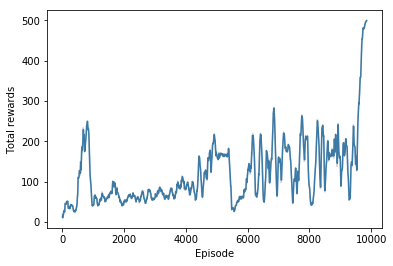

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

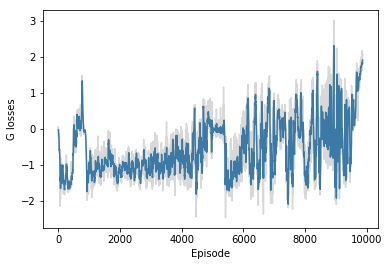

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

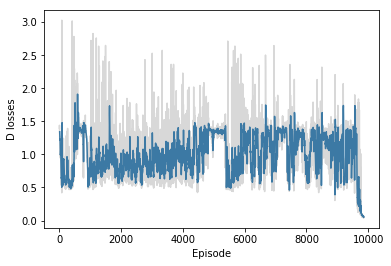

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

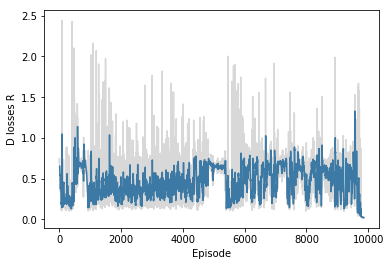

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

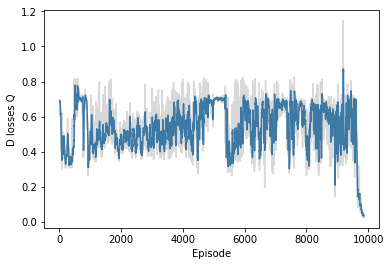

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.